<a href="https://colab.research.google.com/github/ArchitYad/archityadav_AI-project-submission/blob/main/ai_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Employee sentimental analysis on email dataset.

> <b>Reading the employee email dataset</b>


In [ ]:
import pandas as pd
df=pd.read_csv('test.csv')  #data reading.


> <b>Reading the columns.</b>


In [ ]:
df.columns #columns reading

Index(['Subject', 'body', 'date', 'from'], dtype='object')


> <b>Descriptive analysis of dataset like frequency, unique datapoint.</b>

In [ ]:
df.describe() #descriptive analysis.

,Subject,body,date,from
count,2191,2191,2191,2191
unique,1251,1539,690,10
top,(No Subject),\n\n,7/1/2011,lydia.delgado@enron.com
freq,141,21,9,284



><b>Details about the data type in columns and non-null count.</b>



In [ ]:
df.info() #knowing the data types and the non-null count.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB



> <b>Checking null count in dataset.</b>

In [ ]:
df.isnull().sum() #null count for all columns.

,0
Subject,0
body,0
date,0
from,0



><b>Cleaning the text of email.</b>

In [ ]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize

# Dictionary to expand common English contractions
contractions = {
    "can't": "cannot", "wouldn't": "would not", "didn't": "did not", "you're": "you are",
    "i'll": "i will", "it's": "it is", "i'm": "i am", "we're": "we are", "hasn't": "has not",
    "i'd": "i had", "doesn't": "does not", "don't": "do not", "what's": "what is",
    "he's": "he is", "she's": "she is", "we'll": "we will", "where's": "where is"
}

# Function to clean email text
def clean_email_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()  # convert to lowercase for uniformity

    # Step 1: Preserve time expressions to prevent corruption during cleaning
    time_preserve = {}

    def save_time(match):
        key = f"time {len(time_preserve)}"
        time_preserve[key] = match.group(0)
        return key

    # Regular expressions to match various time formats
    time_patterns = [
        r'\b\d{1,2}(:\d{2}){0,2}\s*(am|pm)?\s*[-to]+\s*\d{1,2}(:\d{2}){0,2}(am|pm)?\b',
        r'\b\d{1,2}(:\d{2}){1,2}\s*(am|pm)\b'
    ]
    for pattern in time_patterns:
        text = re.sub(pattern, save_time, text, flags=re.IGNORECASE)

    # Step 2: Preserve date expressions
    date_preserve = {}

    def save_date(match):
        key = f"date {len(date_preserve)}"
        date_preserve[key] = match.group(0)
        return key

    # Match common date formats (DD/MM/YYYY or YYYY-MM-DD)
    text = re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', save_date, text)
    text = re.sub(r'\b\d{4}[/-]\d{1,2}[/-]\d{1,2}\b', save_date, text)

    # Match date ranges like "Jan 3–5"
    month_pattern = r'(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec|' \
                    r'january|february|march|april|may|june|july|august|' \
                    r'september|october|november|december)'
    date_range_pattern = fr'\b{month_pattern}\s+\d{{1,2}}\s*(–|-|to)\s*\d{{1,2}}\b'
    text = re.sub(date_range_pattern, save_date, text, flags=re.IGNORECASE)

    # Step 3: Expand contractions
    for c, full in contractions.items():
        text = re.sub(rf"\b{c}\b", full, text)

    # Step 4: Remove special patterns (like file paths, quotes, signatures)
    text = re.sub(r'\\\\[\w\\]+', '', text) #It aims to remove patterns like "\\word\" or "\\\".
    text = re.sub(r'\\[\w\\]+', '', text) # It aims to remove patterns like "\word\" or "\".
    text = re.sub(r'<<.*?>>', '', text) #It aims to remove content enclosed in double angle brackets.
    text = re.sub(r'>+.*?<+', '', text) #It aims to remove content enclosed in one or more ">" followed by one or more "<".
    text = re.sub(r'(\\n)+|\n+|[\r\n\t]+', ' ', text) # It aims to replace various forms of line breaks and tabs with a single space.
    text = re.sub(r'\n[-*~]*\n', ' ', text) #It aims to replace lines that consist of only hyphens, asterisks, or tildes (often used as separators) with a single space.

    # Step 5: Remove specific tokens
    text = re.sub(r'\[image\]', '', text) #example [image]
    text = re.sub(r'\b[\w.-]+?@[\w.-]+\.\w{2,4}\b', 'email', text)  # emails
    text = re.sub(r'https?://\S+|www\.\S+|mailto:\S+', 'website', text)  # URLs

    # Phone numbers
    text = re.sub(r'\(?\b\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}\b', 'phone number', text)
    text = re.sub(r'\+?\d{1,3}[-.\s]?\d{1,4}[-.\s]?\d{3,5}[-.\s]?\d{4}', 'phone number', text)

    # File extensions
    text = re.sub(r'\b[\w\-.]+\.(docx?|pdf|xls[xm]?|jpg|png|exe|pps|txt|zip|html?)\b', 'file', text, flags=re.IGNORECASE)

    # Step 6: Normalize abbreviations
    text = re.sub(r'\bCorp\.\b', 'Corporation', text)
    text = re.sub(r'\bNat\. Gas\b', 'Natural Gas', text)
    text = re.sub(r'\bNov\.\b', 'November', text)
    text = re.sub(r'\bpg\.\b', 'page', text)

    # Step 7: Normalize price per unit
    text = re.sub(r'\$(\d+(?:\.\d+)?)/(\w+)', r'$\1 per \2', text)

    # Step 8: Remove common email prefixes and metadata
    text = re.sub(r'\b(re|fw|fwd)\s*[:\-]', '', text) #It aims to remove common email prefixes like "Re:", "Fw:", "Fwd-", etc.
    text = re.sub(r'\b(subject|from)\s*[:\-]?', '', text) #It aims to remove the labels "Subject:" or "From:" (and variations) often found in email headers.

    # Step 9: Remove long numbers, unnecessary punctuation, and noise
    text = re.sub(r'\b\d{6,}\b', '', text) #long number
    text = re.sub(r'(?<!\d),(?!\d)', ' ', text) # example word, or 5,9,0 or 9,word
    text = re.sub(r'(?<!\d):|:(?!\d)', ' ', text) # catching colon after digit or word
    text = re.sub(r'[\[\]\(\)<>=_#*]', ' ', text)  # <> (file path inside it)
    text = re.sub(r'\.{2,}|\*{2,}|\?{2,}|[-]{2,}|[~]{2,}', ' ', text) #*~*~ pattern
    text = re.sub(r'\/', ' ', text)  # example path/to/file
    text = re.sub(r'\s*-\s*', ' ', text) # example hello -- world
    text = re.sub(r"[’`]", "'", text) # What`s to What's
    text = re.sub(r"'\s+", " ", text) # remove extra space after ' like it'  s to it' s
    text = re.sub(r'\s+[\"\,\!\?\;\-]+\s*', ' ', text) # example test ? or text;next

    # Final cleaning
    text = text.replace('"', '') # removing ""
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    text = re.sub(r'(~\s*)+', '', text) # extra ~
    text = text.replace("</O=ENRON/OU=NA/CN=RECIPIENTS/CN=DBAUGHM>", "") #uncessary words
    text = re.sub(r'\s*\.\s*', ' ', text) #extra .
    text = re.sub(r'@(?=\w)', 'at ', text) # example message @user123 -> message at user123

    # Restore preserved date and time values
    for key, val in date_preserve.items():
        text = text.replace(key, val)

    for key, val in time_preserve.items():
        text = text.replace(key, val)

    return text.strip()

# Function to remove repeated adjacent words (e.g., "the the" → "the")
def remove_repeated_words(text):
    text = re.sub(r'\b(\w+)\s+\1\b', r'\1', text, flags=re.IGNORECASE)
    return text.strip()

# Step 1: Fill empty body fields with Subject if body is missing
df.loc[(df['body'].str.strip() == '') & (df['Subject'].str.strip() != ''), 'body'] = df['Subject']

# Step 2: Drop rows where both Subject and body are missing
df = df[~((df['Subject'].str.strip() == '') & (df['body'].str.strip() == ''))].reset_index(drop=True)

# Step 3: Apply cleaning functions to email body
df['cleaned_text'] = df['body'].apply(clean_email_text).apply(remove_repeated_words)


><b>Counting number of nan blank rows in cleaned_text column</b>


In [ ]:
onlc=(df['cleaned_text'] == '').sum()
print(f"Number of rows where cleaned_text contains only a nan or blank: {onlc}") #count where cleaned_text contains only a nan or blank

Number of rows where cleaned_text contains only a nan or blank: 11


><b>Removing the rows which have nan or whitespace in cleaned_text column</b>

In [ ]:
import pandas as pd

df = df[~df['cleaned_text'].isnull()] # Remove rows where 'cleaned_text' is null (i.e., missing or NaN)
df = df[df['cleaned_text'].astype(str).str.strip() != ''] # Remove rows where cleaned_text is an empty string or just whitespace

><b>Display most 20 frequent words in cleaned_text</b>

In [ ]:
from collections import Counter
# Combine all cleaned text entries into one long string and split it into individual words
all_words = ' '.join(df['cleaned_text']).split()
# Count the frequency of each word in the list using Python's Counter
word_freq = Counter(all_words)
# Display the top 20 most frequent words and their counts
print("Top 20 most frequent words:")
print(word_freq.most_common(20))

Top 20 most frequent words:
[('the', 3404), ('to', 2730), ('you', 1859), ('and', 1712), ('i', 1623), ('for', 1425), ('a', 1193), ('in', 1137), ('of', 1107), ('on', 1020), ('will', 1013), ('is', 953), ('your', 847), ('have', 833), ('that', 816), ('be', 799), ('this', 748), ('we', 686), ('please', 628), ('with', 587)]


<style>
.insights-section {
  margin-bottom: 20px;
  padding: 15px;
  border: 1px solid #eee;
  border-radius: 5px;
  background-color: #f9f9f9;
}
.section-title {
  font-size: 1.3em;
  font-weight: bold;
  color: #333;
  margin-bottom: 10px;
}
.insight-point {
  margin-bottom: 8px;
  line-height: 1.5;
  color: #555;
}
.word-emphasis {
  font-weight: bold;
  color: #007bff;
}
</style>

<div>
  <div class="insights-section">
    <h3 class="section-title">1. Dominance of Stop Words:</h3>
    <p class="insight-point">
      Words like <span class="word-emphasis">"the"</span>, <span class="word-emphasis">"to"</span>, <span class="word-emphasis">"and"</span>, <span class="word-emphasis">"a"</span>, <span class="word-emphasis">"in"</span>, <span class="word-emphasis">"of"</span>, <span class="word-emphasis">"is"</span> are common stop words that carry low semantic weight.
    </p>
    <p class="insight-point">
      These words tend to dominate unless stop words were removed — if they weren't, consider removing them for certain NLP tasks (like topic modeling).
    </p>
  </div>

  <div class="insights-section">
    <h3 class="section-title">2. Personal Pronouns and Tone:</h3>
    <p class="insight-point">
      High counts for <span class="word-emphasis">"you"</span>, <span class="word-emphasis">"i"</span>, <span class="word-emphasis">"we"</span>, <span class="word-emphasis">"your"</span>, and <span class="word-emphasis">"please"</span> suggest the text is:
    </p>
    <ul>
      <li class="insight-point">Conversational or instructional</li>
      <li class="insight-point">Possibly email/chat/ticket-like in format</li>
      <li class="insight-point">Polite/formal (e.g., "<span class="word-emphasis">please</span>")</li>
    </ul>
  </div>

  <div class="insights-section">
    <h3 class="section-title">3. Modal and Future Tense:</h3>
    <p class="insight-point">
      <span class="word-emphasis">"will"</span>, <span class="word-emphasis">"have"</span>, <span class="word-emphasis">"be"</span> → common in promises, resolutions, or requests.
    </p>
    <p class="insight-point">
      May relate to support tickets, customer communication, or future intent.
    </p>
  </div>

  <div class="insights-section">
    <h3 class="section-title">4. Use of "please":</h3>
    <p class="insight-point">
      628 mentions of <span class="word-emphasis">"please"</span> imply a request-heavy or customer-service tone — useful for detecting politeness or urgency.
    </p>
  </div>
</div>

><b>World Cloud Analysis</b>

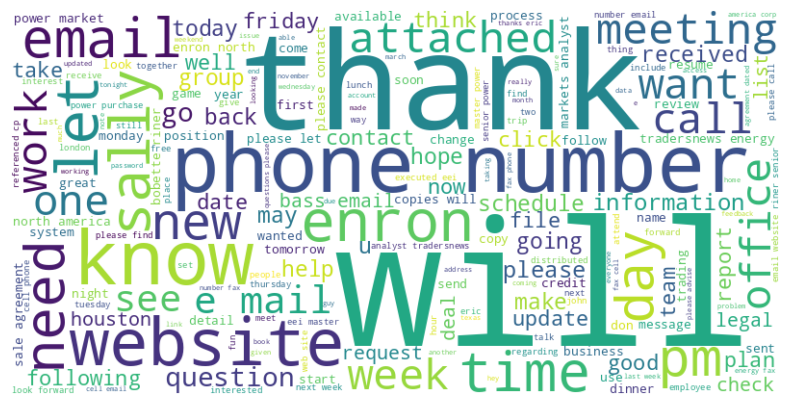

In [ ]:
from wordcloud import WordCloud       # Import WordCloud class for generating word clouds
import matplotlib.pyplot as plt       # Import matplotlib for plotting

# Generate a word cloud from all the cleaned text data
wordcloud = WordCloud(
    width=800,                         # Width of the word cloud image
    height=400,                        # Height of the word cloud image
    background_color='white'          # Background color of the word cloud
).generate(' '.join(df['cleaned_text']))  # Join all cleaned text into one string and generate the word cloud

# Create a figure for displaying the word cloud
plt.figure(figsize=(10, 5))           # Set the size of the figure
plt.imshow(wordcloud, interpolation='bilinear')  # Render the word cloud image smoothly
plt.axis('off')                       # Turn off the axis display
plt.show()                            # Display the word cloud


<style>
.communication-insight {
  margin-bottom: 20px;
  padding: 15px;
  border: 1px solid #e0e0e0;
  border-radius: 5px;
  background-color: #f9f9f9;
}

.insight-title {
  font-size: 1.2em;
  font-weight: bold;
  color: #2c3e50;
  margin-bottom: 10px;
}

.insight-words {
  font-style: italic;
  color: #3498db;
}

.insight-explanation {
  color: #555;
  line-height: 1.6;
}
</style>

<div>
  <div class="communication-insight">
    <h3 class="insight-title">🧾 Likely Email Communication Dataset:</h3>
    <p class="insight-explanation">
      Words like <span class="insight-words">"email"</span>, <span class="insight-words">"attached"</span>, <span class="insight-words">"file"</span>, <span class="insight-words">"number"</span>, <span class="insight-words">"contact"</span>, <span class="insight-words">"office"</span>, <span class="insight-words">"schedule"</span>, <span class="insight-words">"meeting"</span>, <span class="insight-words">"call"</span>, and <span class="insight-words">"phone"</span> all suggest:
    </p>
    <ul class="insight-explanation">
      <li>Customer service interactions</li>
      <li>Internal company communication</li>
      <li>Possibly Enron email data or similar corporate datasets</li>
    </ul>
  </div>

  <div class="communication-insight">
    <h3 class="insight-title">🙏 Politeness & Formality:</h3>
    <p class="insight-explanation">
      Frequent use of <span class="insight-words">"thank"</span>, <span class="insight-words">"please"</span>, <span class="insight-words">"hope"</span>, <span class="insight-words">"help"</span> reflects polite professional tone typical in business or customer emails.
    </p>
  </div>

  <div class="communication-insight">
    <h3 class="insight-title">📅 Time References:</h3>
    <p class="insight-explanation">
      Words like <span class="insight-words">"day"</span>, <span class="insight-words">"week"</span>, <span class="insight-words">"time"</span>, <span class="insight-words">"friday"</span>, <span class="insight-words">"monday"</span>, <span class="insight-words">"tomorrow"</span>, <span class="insight-words">"today"</span> point to scheduling, planning, or time-sensitive requests.
    </p>
  </div>

  <div class="communication-insight">
    <h3 class="insight-title">🧠 Information-Seeking Tone:</h3>
    <p class="insight-explanation">
      Words like <span class="insight-words">"know"</span>, <span class="insight-words">"need"</span>, <span class="insight-words">"see"</span>, <span class="insight-words">"question"</span>, <span class="insight-words">"request"</span> suggest people are asking for or offering information.
    </p>
  </div>

  <div class="communication-insight">
    <h3 class="insight-title">🌐 Digital or Technical Context:</h3>
    <p class="insight-explanation">
      Words like <span class="insight-words">"website"</span>, <span class="insight-words">"click"</span>, <span class="insight-words">"link"</span>, <span class="insight-words">"attached"</span>, <span class="insight-words">"file"</span>, <span class="insight-words">"email"</span>, <span class="insight-words">"number"</span> indicate the messages involve digital or online content/tasks.
    </p>
  </div>
</div>

>Library for Model

In [ ]:
pip install transformers torch #installing libraries

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

<style>
.paragraph-style {
  font-size: 1.1em;
  line-height: 1.6;
  margin-bottom: 1em;
  color: #333;
}
.section-heading {
  font-size: 1.5em;
  font-weight: bold;
  color: #007bff;
  margin-top: 1.5em;
  margin-bottom: 0.5em;
}
.at-risk-table {
  width: 60%;
  border-collapse: collapse;
  margin-top: 1em;
  margin-bottom: 1em;
}
.at-risk-table th, .at-risk-table td {
  border: 1px solid #ddd;
  padding: 8px;
  text-align: left;
}
.at-risk-table th {
  background-color: #f2f2f2;
}
</style>

<h2 class="section-heading">Task 1: Roberta Model used for sentiment labelling.</h2>

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load the pre-trained tokenizer and model for sentiment analysis
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Function to get sentiment label and score
def get_sentiment_label(text):
    try:
        # Analyze only first 512 chars to fit model limits
        result = sentiment_pipeline(text[:512])[0]

        # Map model label to human-readable label
        label_map = {
            'LABEL_0': 'Negative',
            'LABEL_1': 'Neutral',
            'LABEL_2': 'Positive'
        }
        label = label_map[result['label']]
        score = round(result['score'], 3)
        # Return both label and confidence score as a tuple
        return label, score
    except:
        # In case of error, return unknown with zero score
        return "Unknown", 0.0

# Apply function and unpack tuple into two new columns
df[['sentiment', 'score']] = df['cleaned_text'].apply(
    lambda x: pd.Series(get_sentiment_label(x))
)

# Preview results
print(df[['cleaned_text', 'sentiment', 'score']].head())

Device set to use cuda:0


                                        cleaned_text sentiment  score
0  enronoptions announcement we have updated the ...  Positive  0.683
1  marc unfortunately today is not going to work ...  Negative  0.741
2  when wednesday june 06, 2001 10:00 am-11:00 am...   Neutral  0.948
3  we were thinking papasitos we can meet somewhe...   Neutral  0.872
4  since you never gave me the $20 for the last t...   Neutral  0.746


><b>Analysis of Confidence Score</b>

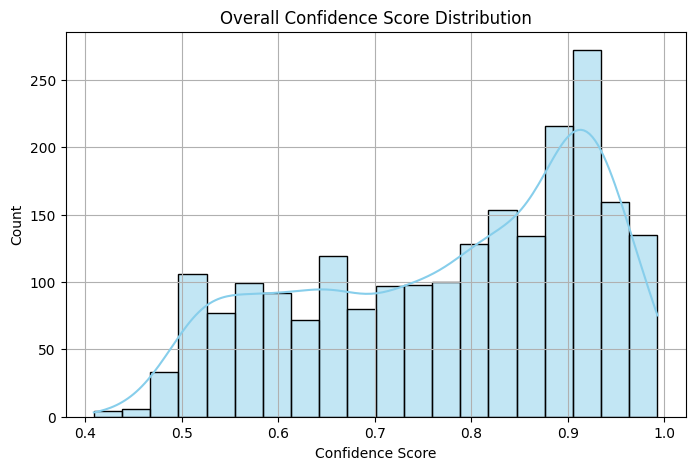

<ipython-input-14-9009bff3e644>:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Predicted Sentiment')


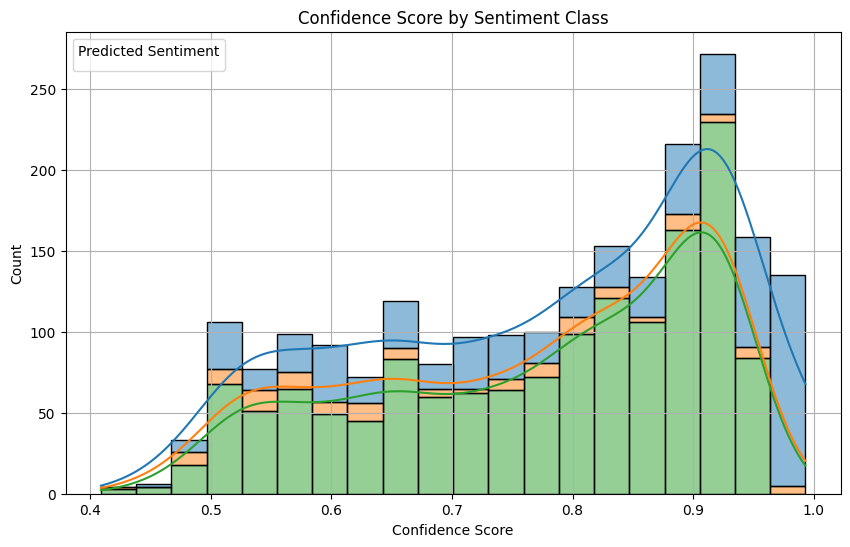

<ipython-input-14-9009bff3e644>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentiment', y='score', palette='Set2')


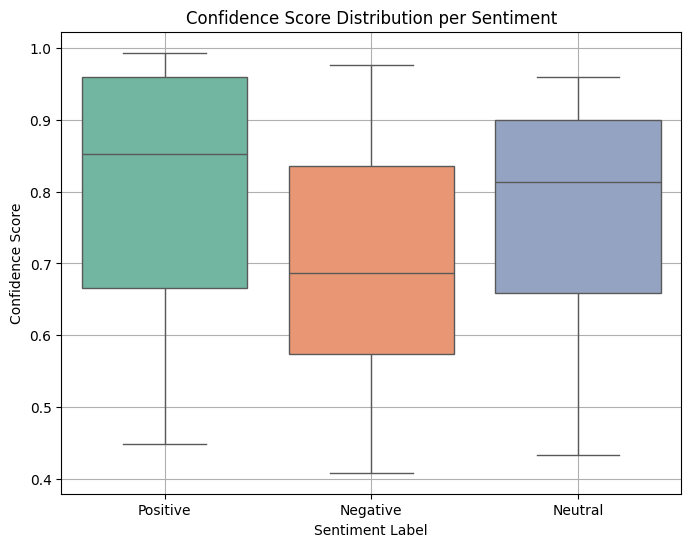


Summary of confidence scores by sentiment class:

            count      mean       std    min     25%     50%      75%    max
sentiment                                                                   
Negative    138.0  0.703399  0.152450  0.409  0.5740  0.6865  0.83575  0.976
Neutral    1447.0  0.774274  0.138635  0.433  0.6590  0.8130  0.89900  0.959
Positive    595.0  0.806793  0.160850  0.449  0.6665  0.8520  0.95900  0.993


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Overall confidence score distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['score'], bins=20, kde=True, color='skyblue')
plt.title('Overall Confidence Score Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 2. Confidence score distribution per predicted sentiment class
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='score', hue='sentiment', bins=20, kde=True, multiple='stack')
plt.title('Confidence Score by Sentiment Class')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.grid(True)
plt.legend(title='Predicted Sentiment')
plt.show()

# 3. Boxplot to see score variation per class
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='sentiment', y='score', palette='Set2')
plt.title('Confidence Score Distribution per Sentiment')
plt.xlabel('Sentiment Label')
plt.ylabel('Confidence Score')
plt.grid(True)
plt.show()

# 4. Summary statistics per class
print("\nSummary of confidence scores by sentiment class:\n")
print(df.groupby('sentiment')['score'].describe())

<style>
.confidence-table {
  width: 70%;
  border-collapse: collapse;
  margin-top: 20px;
}
.confidence-table th, .confidence-table td {
  border: 1px solid #ddd;
  padding: 10px;
  text-align: left;
}
.confidence-table th {
  background-color: #f2f2f2;
}
.positive {
  color: green;
  font-weight: bold;
}
.neutral {
  color: orange;
  font-weight: bold;
}
.negative {
  color: red;
  font-weight: bold;
}
</style>

<div>
  <h2>Sentiment Confidence Verdict</h2>
  <table class="confidence-table">
    <thead>
      <tr>
        <th>Sentiment</th>
        <th>Confidence Level</th>
        <th>Verdict</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td class="positive">Positive</td>
        <td>Most confidently predicted.</td>
        <td>High model certainty.</td>
      </tr>
      <tr>
        <td class="neutral">Neutral</td>
        <td>Confident, but with some tail uncertainty.</td>
        <td>Possibly overlaps with both Positive and Negative.</td>
      </tr>
      <tr>
        <td class="negative">Negative</td>
        <td>Least confident.</td>
        <td>Needs more training examples or better class separation.</td>
      </tr>
    </tbody>
  </table>
</div>

<style>
.paragraph-style {
  font-size: 1.1em;
  line-height: 1.6;
  margin-bottom: 1em;
  color: #333;
}
.section-heading {
  font-size: 1.5em;
  font-weight: bold;
  color: #007bff;
  margin-top: 1.5em;
  margin-bottom: 0.5em;
}
.at-risk-table {
  width: 60%;
  border-collapse: collapse;
  margin-top: 1em;
  margin-bottom: 1em;
}
.at-risk-table th, .at-risk-table td {
  border: 1px solid #ddd;
  padding: 8px;
  text-align: left;
}
.at-risk-table th {
  background-color: #f2f2f2;
}
</style>

<h2 class="section-heading">Task 2: EDA Analysis of Sentiment Data.</h2>

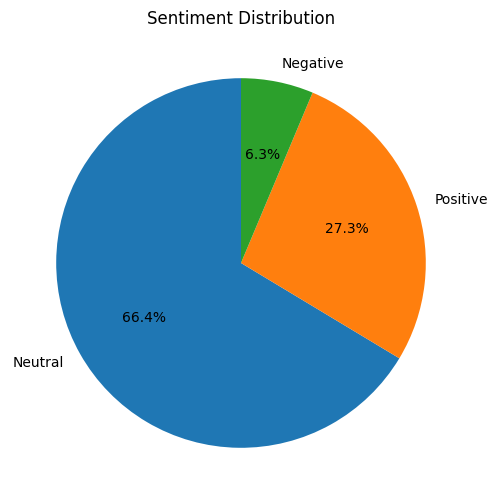

<ipython-input-15-6a7af504b2f6>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


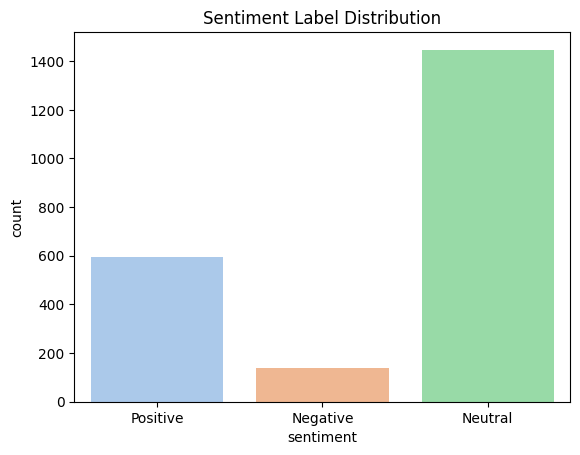

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment label in the dataframe
sentiment_counts = df['sentiment'].value_counts()

# Plot a pie chart showing the percentage distribution of sentiment labels
sentiment_counts.plot.pie(
    autopct='%1.1f%%',   # Show percentages with 1 decimal place
    startangle=90,       # Start the pie chart from 90 degrees (top)
    figsize=(6,6),       # Set figure size to 6x6 inches
    title='Sentiment Distribution'  # Title of the pie chart
)
plt.ylabel('')           # Remove default y-label for cleaner look
plt.show()               # Display the pie chart

# Plot a count plot (bar plot) of sentiment labels using seaborn
sns.countplot(
    data=df,              # Data source
    x='sentiment',        # Column to plot on x-axis
    palette='pastel'      # Use pastel color palette for bars
)
plt.title('Sentiment Label Distribution')  # Title of the bar chart
plt.show()                                # Display the bar chart

><b>Neutral is more common and negative least common.</b>

><b>Trends in Sentiment</b>

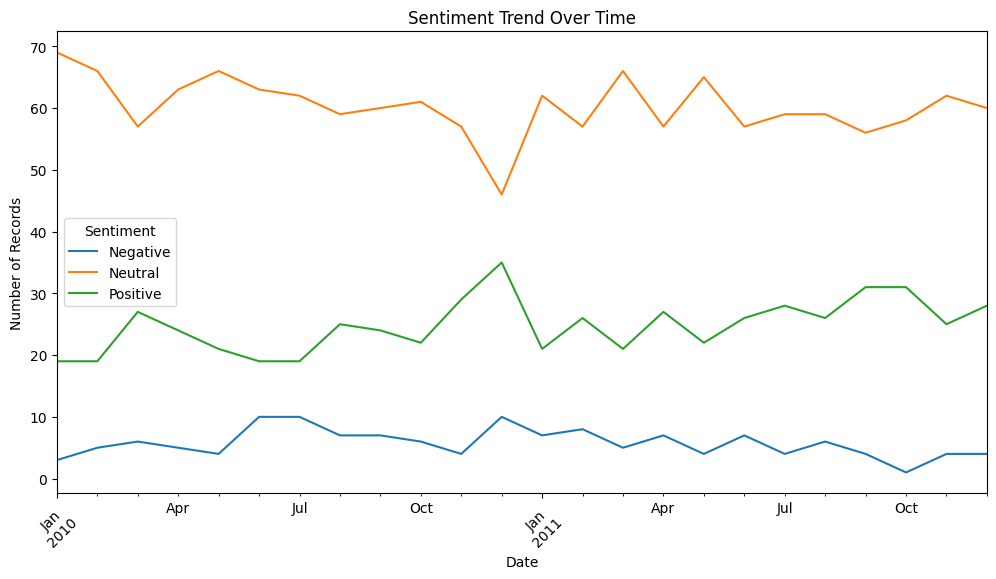

In [ ]:
# Convert the 'date' column to datetime format for proper time-based operations
df['date'] = pd.to_datetime(df['date'])
# Group data by month
sentiment_over_time = df.groupby([df['date'].dt.to_period('M'), 'sentiment']).size().unstack().fillna(0)
# Plot the sentiment counts over time as a line plot
sentiment_over_time.plot(figsize=(12,6), title='Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()

>Neutral sentiment **dominates** the data, with the largest volume of records consistently over time. Positive sentiment is the **next most common**, with some variation but a relatively stable trend. Negative sentiment is the **least common**, occurring much less frequently than the others.


><b>Raw data length analysis</b>



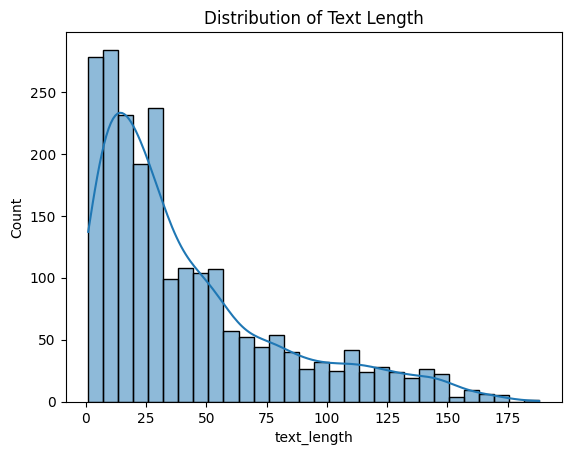

In [ ]:
# Create a new column 'text_length' that stores the number of words in each text body
df['text_length'] = df['body'].apply(lambda x: len(str(x).split()))

# Plot a histogram of text lengths with a Kernel Density Estimate (KDE) overlaid
sns.histplot(df['text_length'], kde=True, bins=30)

# Add a title to the histogram
plt.title('Distribution of Text Length')

# Display the plot
plt.show()

The majority of texts are concentrated on the left side, especially in the 0–30 word range.

The highest bars are for texts with 5–25 words, meaning most of your entries are relatively short.

There are some outliers with lengths even over 150 words, but they are rare.

>**Outliers analysis** on text_length based on sentiment.

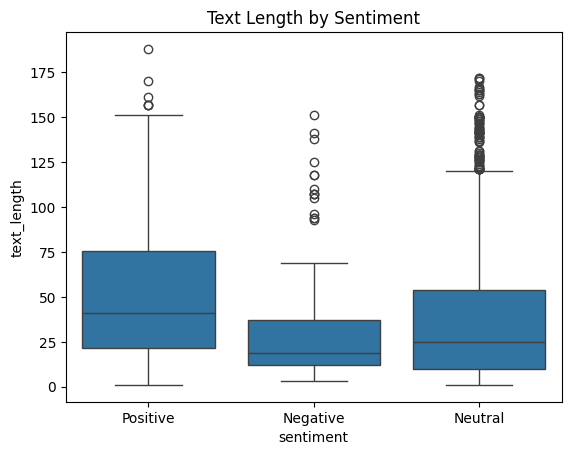

In [ ]:
sns.boxplot(x='sentiment', y='text_length', data=df)  # Creates a boxplot showing distribution of text lengths grouped by sentiment labels
plt.title('Text Length by Sentiment')                # Sets the title of the plot
plt.show()                                           # Displays the plot

>Positive texts tend to be **longer on average and have more variation in length**. Negative texts tend to be **shorter and more consistent in length**. Neutral texts fall in between but have many **long outliers**.

><b>Analysis of unique and common words in cleaned_text</b>

In [ ]:
import pandas as pd
from collections import Counter  # To count word frequencies efficiently
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt_tab')  # for tokenizer
nltk.download('stopwords')  # Downloading standard stopword list

stop_words = set(stopwords.words('english'))  # List of common English stopwords (e.g., "the", "is")
punctuation = set(string.punctuation)         # Set of punctuation marks to remove

def preprocess(text):
    tokens = word_tokenize(text.lower())  # Convert to lowercase and tokenize the text
    words = [word for word in tokens if word.isalpha() and word not in stop_words and word not in punctuation]
    return words  # Return cleaned list of words (no numbers, no stopwords, no punctuation)

sentiment_word_counts = {}

for sentiment in ['Positive', 'Negative', 'Neutral']:
    subset = df[df['sentiment'] == sentiment]  # Filter rows with the current sentiment

    all_words = []
    for text in subset['cleaned_text']:       # Loop through each text entry
        all_words.extend(preprocess(text))    # Preprocess and accumulate words

    word_freq = Counter(all_words)            # Count word frequencies

    sentiment_word_counts[sentiment] = word_freq

    print(f"\n🔹 Top 20 Common Words in {sentiment} Sentiment:")
    for word, freq in word_freq.most_common(20):  # Print top 20 words for that sentiment
        print(f"{word}: {freq}")

print("\n🔹 Unique Words per Sentiment:")
all_sentiments = set(sentiment_word_counts.keys())  # ['Positive', 'Negative', 'Neutral']

for sentiment in all_sentiments:
    other_words = set()
    for other in all_sentiments - {sentiment}:
        other_words |= set(sentiment_word_counts[other].keys())  # Combine words from other sentiments

    unique_words = set(sentiment_word_counts[sentiment].keys()) - other_words  # Words exclusive to this sentiment
    print(f"{sentiment}: {sorted(list(unique_words))[:20]}")  # Display up to 20 unique words

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



🔹 Top 20 Common Words in Positive Sentiment:
thanks: 212
enron: 149
please: 141
email: 134
number: 132
would: 126
phone: 125
sally: 122
get: 115
know: 115
time: 110
pm: 93
website: 89
work: 87
hope: 84
good: 84
week: 78
great: 75
thank: 74
let: 71

🔹 Top 20 Common Words in Negative Sentiment:
please: 41
email: 27
enron: 25
pm: 23
time: 15
office: 14
thanks: 14
week: 14
phone: 13
e: 13
know: 12
website: 12
get: 12
bass: 12
meeting: 11
make: 11
mail: 11
friday: 11
day: 11
going: 10

🔹 Top 20 Common Words in Neutral Sentiment:
please: 446
email: 289
phone: 270
enron: 269
number: 262
website: 250
thanks: 242
know: 212
power: 208
let: 167
e: 153
file: 143
questions: 142
need: 130
time: 129
new: 128
call: 124
pm: 123
information: 121
attached: 118

🔹 Unique Words per Sentiment:
Positive: ['ability', 'abou', 'abrupt', 'absorption', 'ac', 'acacia', 'acceptances', 'accomplish', 'accountant', 'achieve', 'achievement', 'achievements', 'acquaintances', 'acquires', 'acquisitions', 'actions', 'acti

<style>
.paragraph-style {
  font-size: 1.1em;
  line-height: 1.6;
  margin-bottom: 1em;
  color: #333;
}
.section-heading {
  font-size: 1.5em;
  font-weight: bold;
  color: #007bff;
  margin-top: 1.5em;
  margin-bottom: 0.5em;
}
</style>

<h2 class="section-heading">Sentiment-Specific Terminology and Word Frequencies</h2>

<p class="paragraph-style">
  Negative messages contain unique terms such as “acceptable”, “blamed”, and “burning”, which may reflect complaints or issues.
  Positive messages show unique words like “achievement”, “actively”, and “accomplish”, emphasizing optimism and proactive behavior.
</p>

<p class="paragraph-style">
  In positive sentiment messages, words such as “thanks” (212 occurrences), “please” (141), “hope” (84), and “great” (75) dominate, reflecting polite, courteous, and optimistic communication.
  Names like “sally” also appear frequently, indicating personal or direct references common in positive emails.
</p>

<p class="paragraph-style">
  In contrast, negative sentiment messages exhibit a different pattern. While some words overlap with positive messages—like “please” (41), “email” (27), and “time” (15)—there is a notable presence of terms related to logistical or potentially problematic contexts, such as “office” (14), “meeting” (11), and “going” (10). The lower counts overall also suggest fewer negative messages compared to positive and neutral.
</p>

<p class="paragraph-style">
  The neutral sentiment class has the highest volume of messages and shows frequent use of practical and informational words such as “please” (446), “email” (289), “phone” (270), “website” (250), and “file” (143). This aligns with neutral communications often containing requests, facts, or instructions.
</p>

><b>Text analysis based on length, unique words, punctuation characters</b>

In [ ]:
meta = {}  # Dictionary to store all the metadata
meta['num_records'] = len(df)  # Total number of records in the dataset
meta['num_classes'] = df['sentiment'].nunique()  # Number of unique sentiment classes
meta['class_distribution'] = df['sentiment'].value_counts(normalize=True).to_dict()
# Class distribution as proportions (normalized value counts)
meta['avg_text_length'] = df['cleaned_text'].apply(lambda x: len(x.split())).mean()
# Average number of words per text
meta['max_text_length'] = df['cleaned_text'].apply(lambda x: len(x.split())).max()
meta['min_text_length'] = df['cleaned_text'].apply(lambda x: len(x.split())).min()

# Maximum and minimum word counts in individual text entries
from collections import Counter
all_tokens = ' '.join(df['cleaned_text']).lower().split()  # Combine all texts into one big list of words
meta['vocab_size'] = len(set(all_tokens))  # Number of unique words (vocabulary size)
meta['total_words'] = len(all_tokens)  # Total number of words (non-unique)

import numpy as np
meta['avg_word_length'] = np.mean([len(word) for word in all_tokens if word.isalpha()])
# Average character length of valid words (ignoring numbers/symbols)

import string
meta['punctuation_ratio'] = df['cleaned_text'].apply(
    lambda x: sum(1 for char in x if char in string.punctuation) / len(x) if len(x) > 0 else 0
).mean()
# Measures average fraction of punctuation characters per text (helps assess "noisiness")

for k, v in meta.items():
    print(f"{k}: {v}")  # Print each metadata entry

num_records: 2180
num_classes: 3
class_distribution: {'Neutral': 0.6637614678899083, 'Positive': 0.27293577981651373, 'Negative': 0.06330275229357799}
avg_text_length: 42.054587155963304
max_text_length: 192
min_text_length: 1
vocab_size: 8161
total_words: 91679
avg_word_length: 4.521338608483941
punctuation_ratio: 0.014056517836553869


>1. For LSTM: truncate to 150–180 tokens.
2. For TF-IDF or Random Forest: try unigrams + bigrams.
3. For Transformers (e.g., BERT): they handle up to 512 tokens.

><b>Word Overlap Analysis for each sentiment</b>

📊 Jaccard Similarity Scores:
Positive vs Negative: 0.7391304347826086
Positive vs Neutral : 0.8181818181818182
Negative vs Neutral : 0.7391304347826086


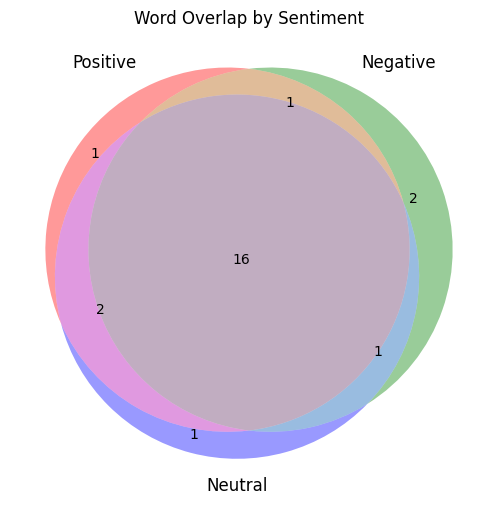

In [ ]:
from collections import Counter  # For counting word frequencies
import matplotlib.pyplot as plt  # For plotting the Venn diagram
import seaborn as sns  # (Not used here, but useful for future plots)

# Function to get the top 'n' most common words for a specific sentiment
def get_top_words(df, label, n=20):
    words = ' '.join(df[df['sentiment'] == label]['cleaned_text']).split()  # Combine all text for the sentiment and split into words
    return Counter(words).most_common(n)  # Count word frequencies and return the top 'n'

# Get top 20 words for each sentiment class
top_pos = get_top_words(df, 'Positive', 20)
top_neg = get_top_words(df, 'Negative', 20)
top_neu = get_top_words(df, 'Neutral', 20)

# Convert word-frequency tuples into sets of words for Jaccard and Venn
pos_words = set([word for word, _ in top_pos])  # Set of top positive words
neg_words = set([word for word, _ in top_neg])  # Set of top negative words
neu_words = set([word for word, _ in top_neu])  # Set of top neutral words

# Function to compute Jaccard similarity between two word sets
def jaccard_score(set1, set2):
    return len(set1 & set2) / len(set1 | set2)  # Intersection over union

# Print Jaccard similarity scores between each pair of sentiment sets
print("📊 Jaccard Similarity Scores:")
print("Positive vs Negative:", jaccard_score(pos_words, neg_words))
print("Positive vs Neutral :", jaccard_score(pos_words, neu_words))
print("Negative vs Neutral :", jaccard_score(neg_words, neu_words))

# Plot Venn diagram showing word overlap among the three sentiment sets
from matplotlib_venn import venn3
plt.figure(figsize=(8, 6))  # Set figure size
venn3([pos_words, neg_words, neu_words], ('Positive', 'Negative', 'Neutral'))  # Create Venn diagram
plt.title("Word Overlap by Sentiment")  # Title for the plot
plt.show()  # Display the plot

>Neutral and positive messages likely use very similar language, which may **suggest difficulty in separating the two with basic word counts**.Negative messages may still use terms also present in neutral ones, possibly due to tone or **shared context**.

<style>
.paragraph-style {
  font-size: 1.1em;
  line-height: 1.6;
  margin-bottom: 1em;
  color: #333;
}
.section-heading {
  font-size: 1.5em;
  font-weight: bold;
  color: #007bff;
  margin-top: 1.5em;
  margin-bottom: 0.5em;
}
.at-risk-table {
  width: 60%;
  border-collapse: collapse;
  margin-top: 1em;
  margin-bottom: 1em;
}
.at-risk-table th, .at-risk-table td {
  border: 1px solid #ddd;
  padding: 8px;
  text-align: left;
}
.at-risk-table th {
  background-color: #f2f2f2;
}
</style>

<h2 class="section-heading">Task 3: Grouping user with month for sentiment score analysis.</h2>

In [ ]:
import pandas as pd

# Convert date to datetime and extract year-month
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.to_period('M')

# Function to assign +1 / -1 / 0 sentiment score per message
def simple_sentiment_score(row):
    if row['sentiment'] == 'Positive':
        return 1
    elif row['sentiment'] == 'Negative':
        return -1
    else:
        return 0

# Apply the scoring function
df['sentiment_score'] = df.apply(simple_sentiment_score, axis=1)

# Group by employee and month, summing sentiment scores
monthly_scores = df.groupby(['from', 'year_month'])['sentiment_score'].sum().reset_index()

# Preview
print(monthly_scores.head())

                          from year_month  sentiment_score
0  bobette.riner@ipgdirect.com    2010-01                0
1  bobette.riner@ipgdirect.com    2010-02                4
2  bobette.riner@ipgdirect.com    2010-03                2
3  bobette.riner@ipgdirect.com    2010-04                1
4  bobette.riner@ipgdirect.com    2010-05                2


>As per current user the sentiment score is highest in 2nd month and for rest it is either positive or neutral.

>Visualization

<ipython-input-23-dc70db0866e7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employee_data['year_month'] = employee_data['year_month'].astype(str)


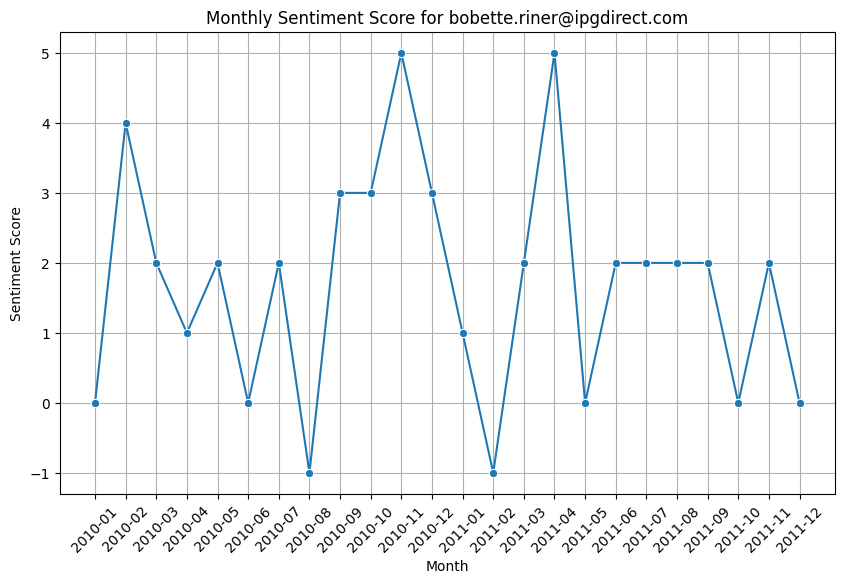

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for the specific employee email
employee_email = 'bobette.riner@ipgdirect.com'
employee_data = monthly_scores[monthly_scores['from'] == employee_email]

# Ensure 'year_month' column is treated as a string for proper x-axis labeling
employee_data['year_month'] = employee_data['year_month'].astype(str)

# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Create a line plot with markers for monthly sentiment scores
sns.lineplot(x='year_month', y='sentiment_score', data=employee_data, marker='o')

# Add title and axis labels for clarity
plt.title(f'Monthly Sentiment Score for {employee_email}')
plt.xlabel('Month')
plt.ylabel('Sentiment Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid lines for easier value estimation
plt.grid(True)

# Display the plot
plt.show()

>For bobette around 7th month and start of 2011 was not good in terms of sentiment score.

<style>
.paragraph-style {
  font-size: 1.1em;
  line-height: 1.6;
  margin-bottom: 1em;
  color: #333;
}
.section-heading {
  font-size: 1.5em;
  font-weight: bold;
  color: #007bff;
  margin-top: 1.5em;
  margin-bottom: 0.5em;
}
.at-risk-table {
  width: 60%;
  border-collapse: collapse;
  margin-top: 1em;
  margin-bottom: 1em;
}
.at-risk-table th, .at-risk-table td {
  border: 1px solid #ddd;
  padding: 8px;
  text-align: left;
}
.at-risk-table th {
  background-color: #f2f2f2;
}
</style>

<h2 class="section-heading">Task 4: Month-wise top 3 user with positive and negative sentiment.</h2>


📅 Rankings for 2010-01
Top Three Positive Employees:
                       from  weighted_score
2       eric.bass@enron.com        0.719369
7  patti.thompson@enron.com        0.719369
4   johnny.palmer@enron.com        0.648637
Top Three Negative Employees:
                   from  weighted_score
9  sally.beck@enron.com       -0.255843


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


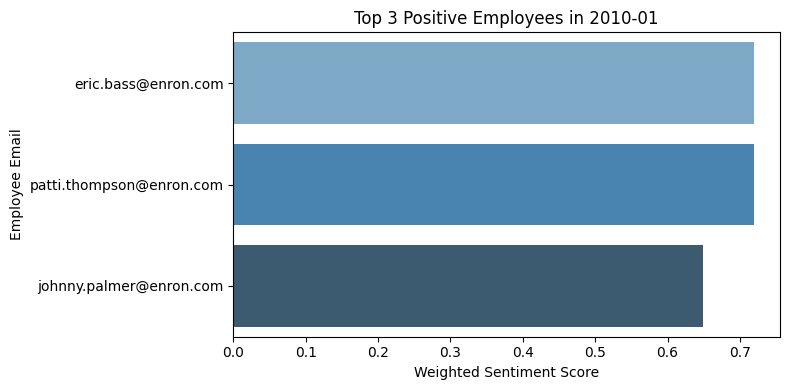

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


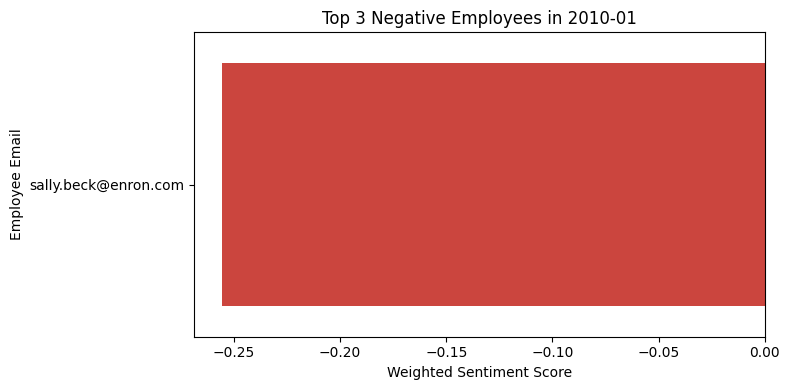

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-02
Top Three Positive Employees:
                           from  weighted_score
12          eric.bass@enron.com        0.804719
10  bobette.riner@ipgdirect.com        0.773729
11       don.baughman@enron.com        0.739357
Top Three Negative Employees:
                       from  weighted_score
19     sally.beck@enron.com       -0.324318
15  kayne.coulter@enron.com       -0.274653


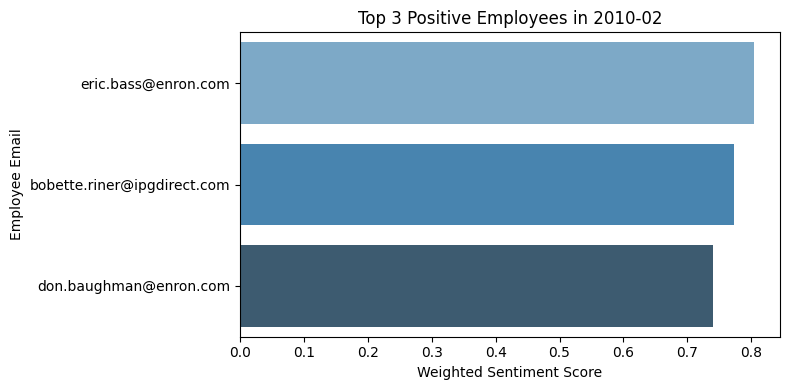

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


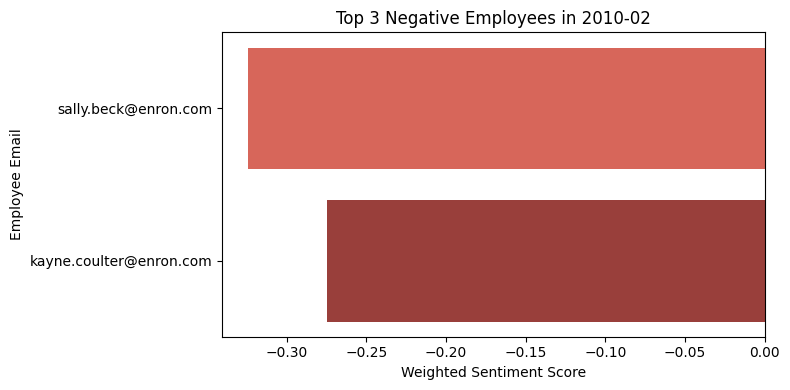

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-03
Top Three Positive Employees:
                        from  weighted_score
29      sally.beck@enron.com        1.068729
27  patti.thompson@enron.com        0.823959
23     john.arnold@enron.com        0.680087
Top Three Negative Employees:
                      from  weighted_score
21  don.baughman@enron.com       -0.402359


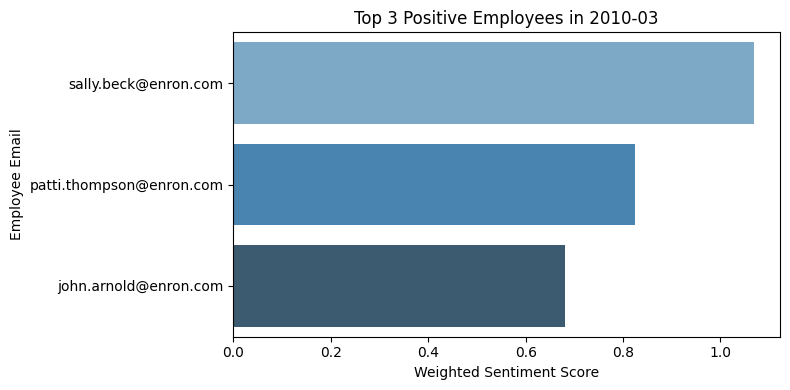

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


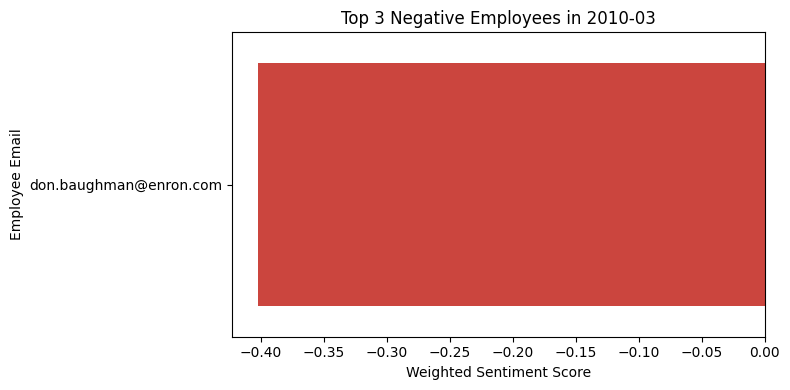

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-04
Top Three Positive Employees:
                       from  weighted_score
33    john.arnold@enron.com        1.023371
35  kayne.coulter@enron.com        0.708303
39     sally.beck@enron.com        0.648637
No Negative Sentiment Users this month (excluding top positives).


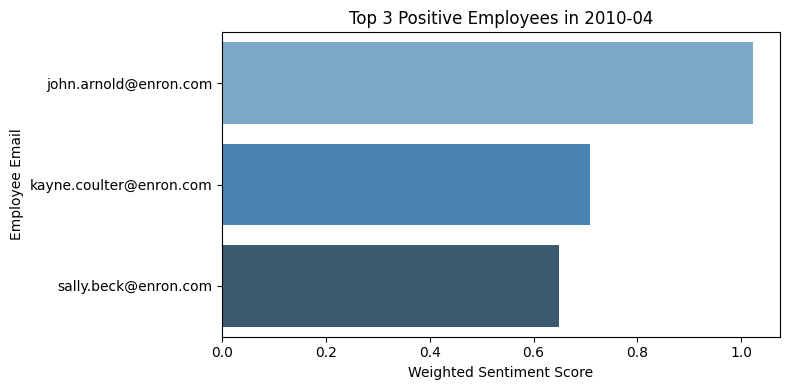


📅 Rankings for 2010-05
Top Three Positive Employees:
                           from  weighted_score
42          eric.bass@enron.com        1.188252
49         sally.beck@enron.com        0.854983
40  bobette.riner@ipgdirect.com        0.804719
No Negative Sentiment Users this month (excluding top positives).


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


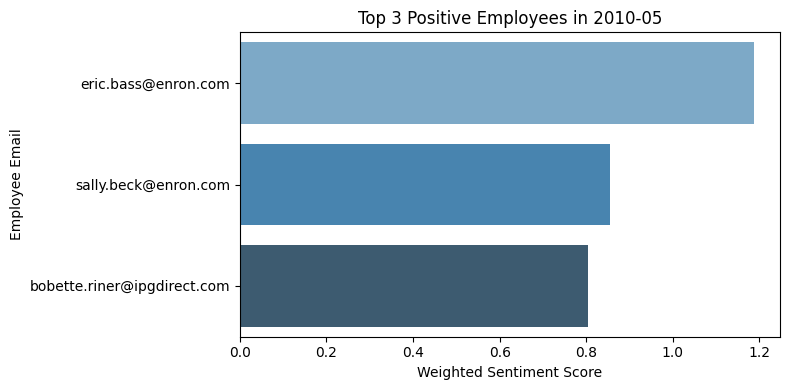


📅 Rankings for 2010-06
Top Three Positive Employees:
                       from  weighted_score
51   don.baughman@enron.com        0.680087
59     sally.beck@enron.com        0.609013
54  johnny.palmer@enron.com        0.479579
Top Three Negative Employees:
                       from  weighted_score
55  kayne.coulter@enron.com       -0.804719


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


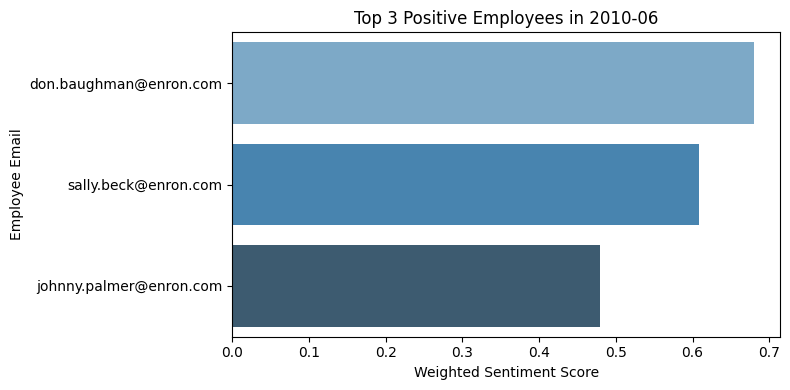

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


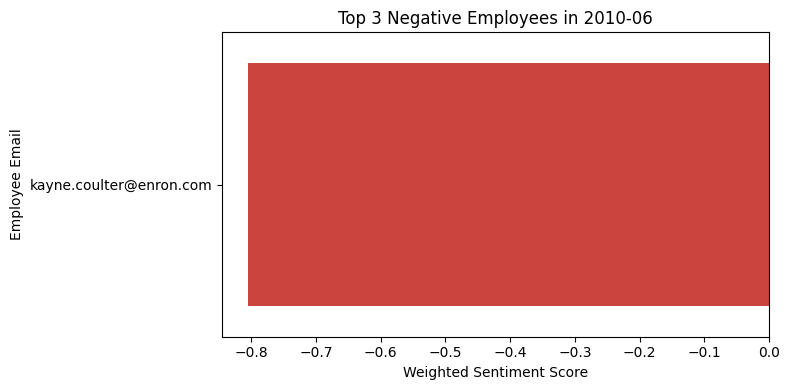

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-07
Top Three Positive Employees:
                           from  weighted_score
61       don.baughman@enron.com        0.648637
66      lydia.delgado@enron.com        0.490740
60  bobette.riner@ipgdirect.com        0.427492
Top Three Negative Employees:
                       from  weighted_score
68  rhonda.denton@enron.com       -0.462098


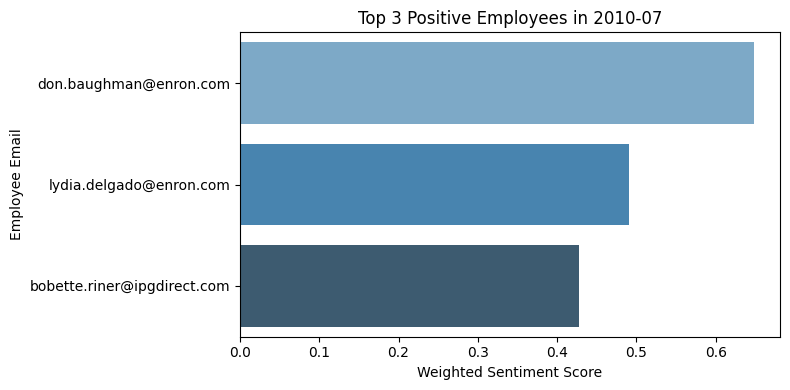

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


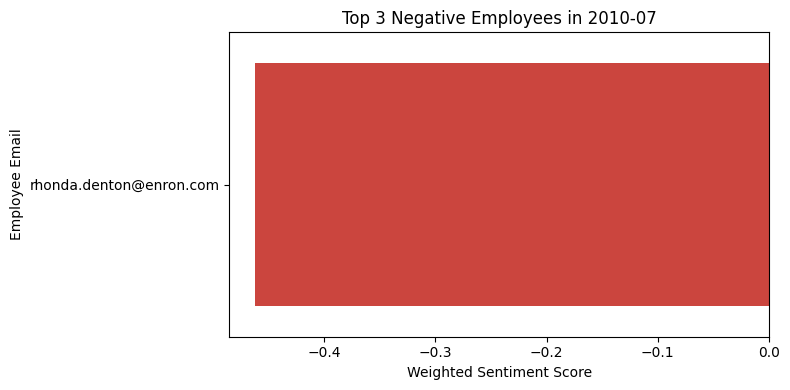

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-08
Top Three Positive Employees:
                       from  weighted_score
71   don.baughman@enron.com        1.098612
75  kayne.coulter@enron.com        0.891189
73    john.arnold@enron.com        0.719369
Top Three Negative Employees:
                           from  weighted_score
70  bobette.riner@ipgdirect.com       -0.255843


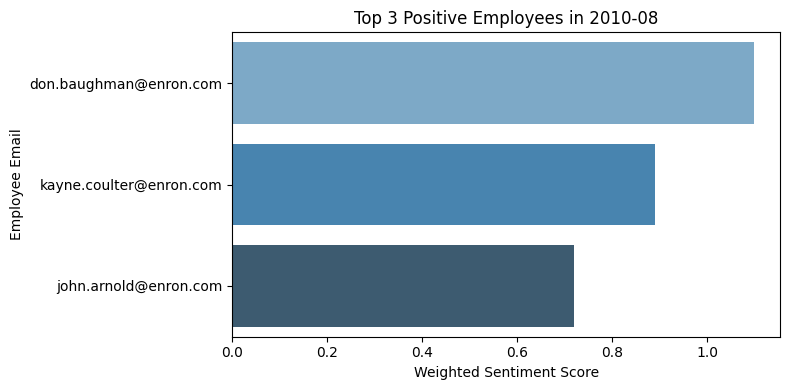

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


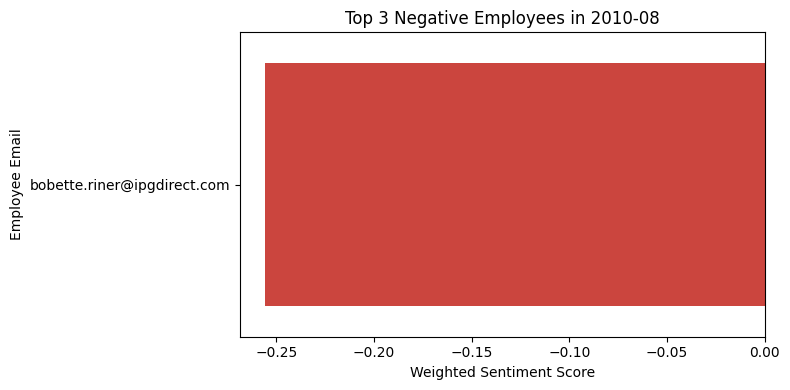

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-09
Top Three Positive Employees:
                        from  weighted_score
88   rhonda.denton@enron.com        1.075056
87  patti.thompson@enron.com        0.959158
89      sally.beck@enron.com        0.891189
Top Three Negative Employees:
                      from  weighted_score
81  don.baughman@enron.com       -0.297063


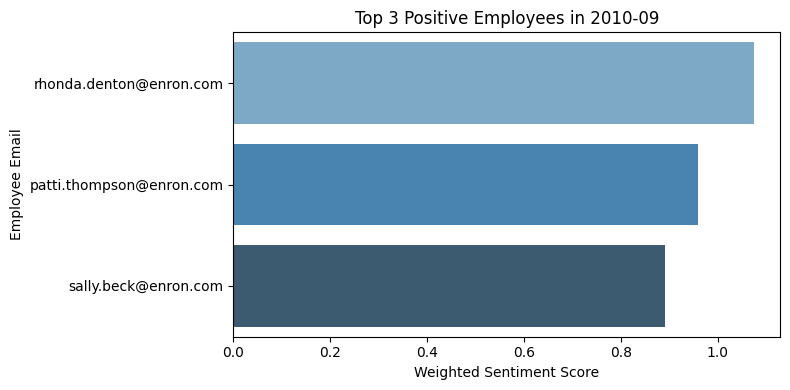

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


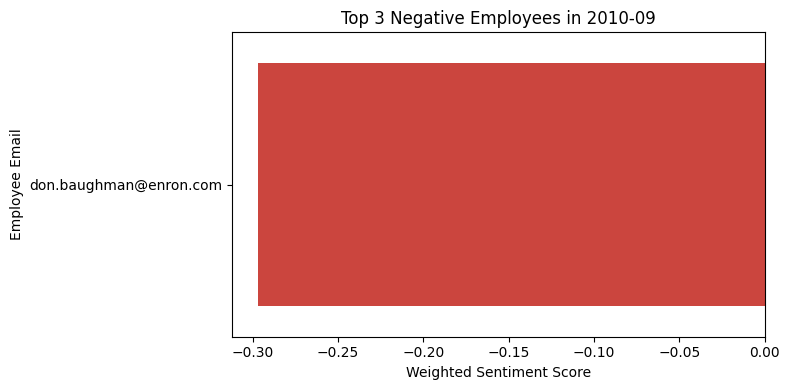

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-10
Top Three Positive Employees:
                           from  weighted_score
90  bobette.riner@ipgdirect.com        0.972955
96      lydia.delgado@enron.com        0.913357
92          eric.bass@enron.com        0.767528
Top Three Negative Employees:
                        from  weighted_score
97  patti.thompson@enron.com       -0.170022


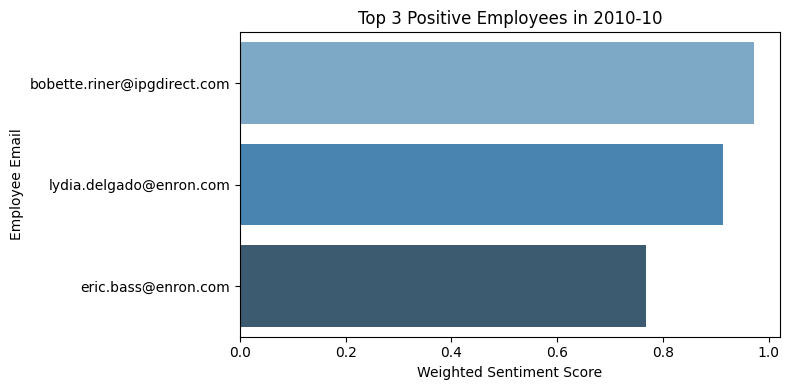

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


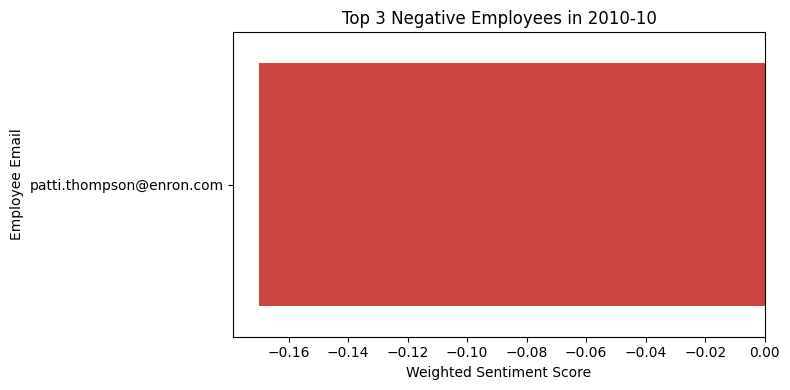


📅 Rankings for 2010-11
Top Three Positive Employees:
                            from  weighted_score
103        john.arnold@enron.com        0.903602
100  bobette.riner@ipgdirect.com        0.885379
107     patti.thompson@enron.com        0.854983
No Negative Sentiment Users this month (excluding top positives).


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


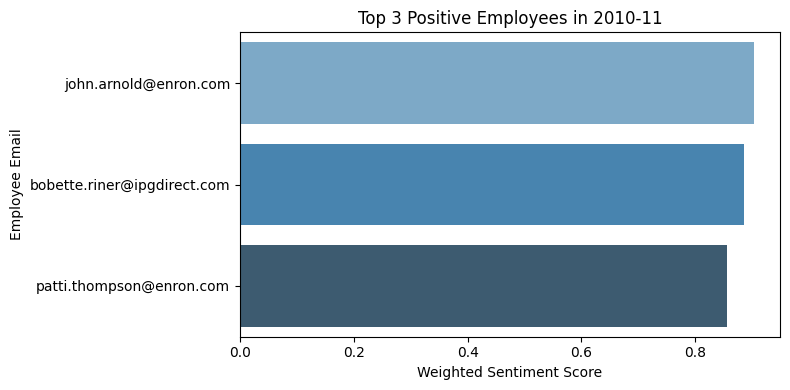


📅 Rankings for 2010-12
Top Three Positive Employees:
                        from  weighted_score
116  lydia.delgado@enron.com        1.218026
113    john.arnold@enron.com        1.177540
119     sally.beck@enron.com        0.903602
Top Three Negative Employees:
                       from  weighted_score
111  don.baughman@enron.com        -0.16358


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


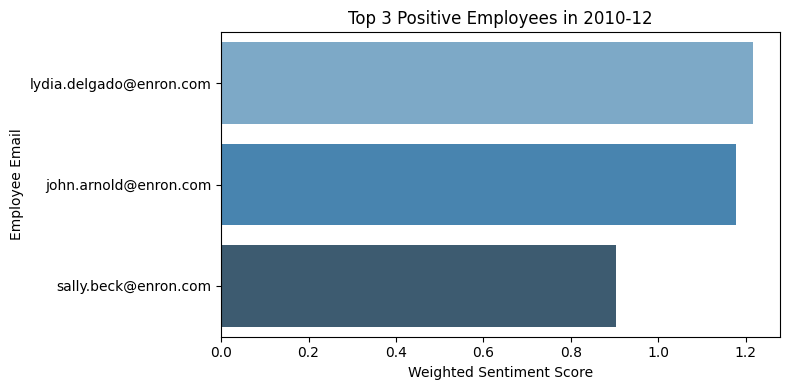

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


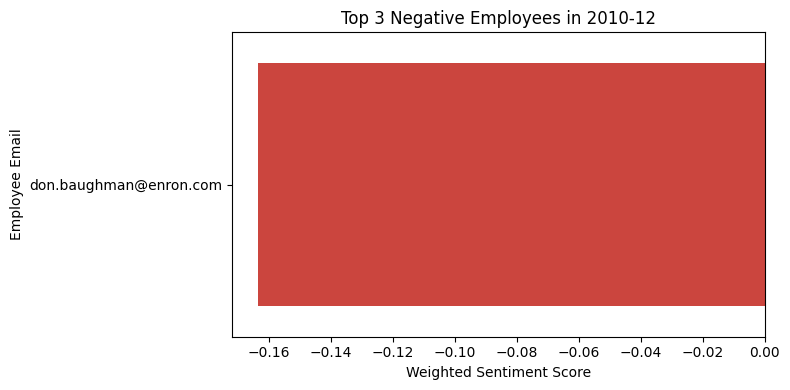

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2011-01
Top Three Positive Employees:
                        from  weighted_score
124  johnny.palmer@enron.com        1.282475
122      eric.bass@enron.com        0.641237
121   don.baughman@enron.com        0.511686
Top Three Negative Employees:
                        from  weighted_score
125  kayne.coulter@enron.com       -0.358352


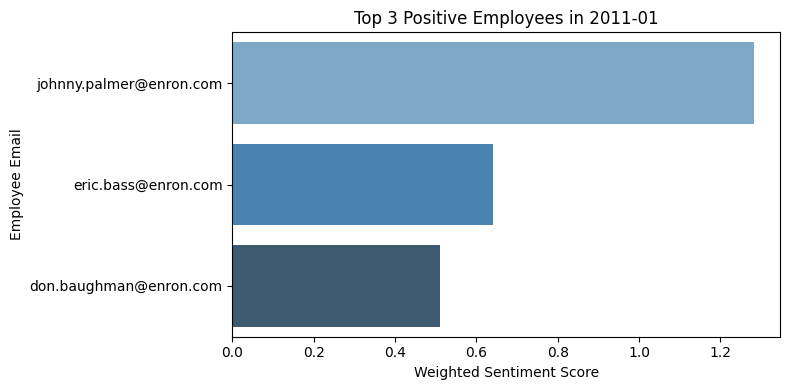

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


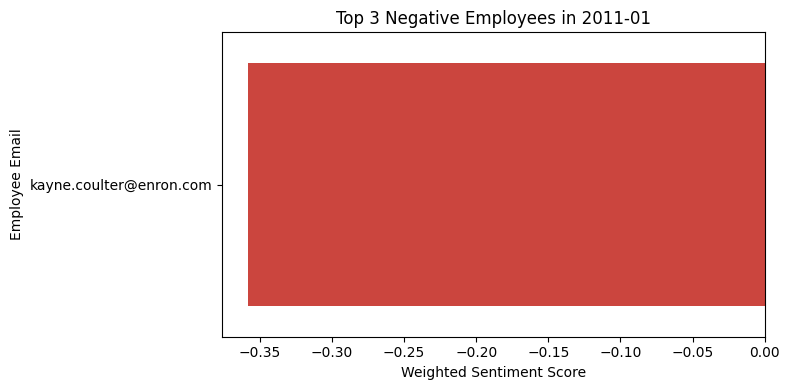

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2011-02
Top Three Positive Employees:
                         from  weighted_score
134   johnny.palmer@enron.com        1.020131
133     john.arnold@enron.com        0.946021
137  patti.thompson@enron.com        0.924196
Top Three Negative Employees:
                            from  weighted_score
130  bobette.riner@ipgdirect.com       -0.462098


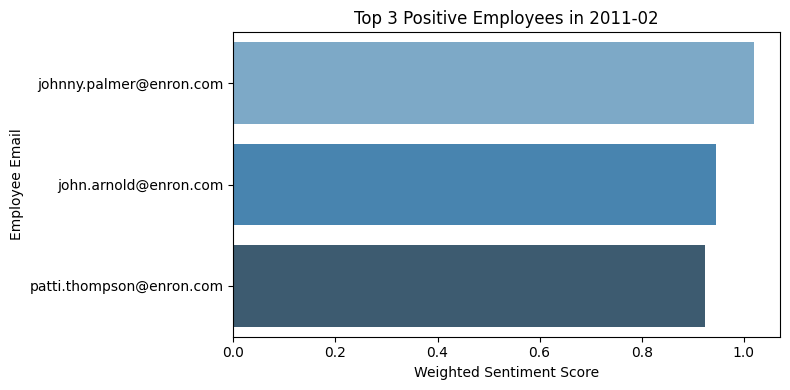

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


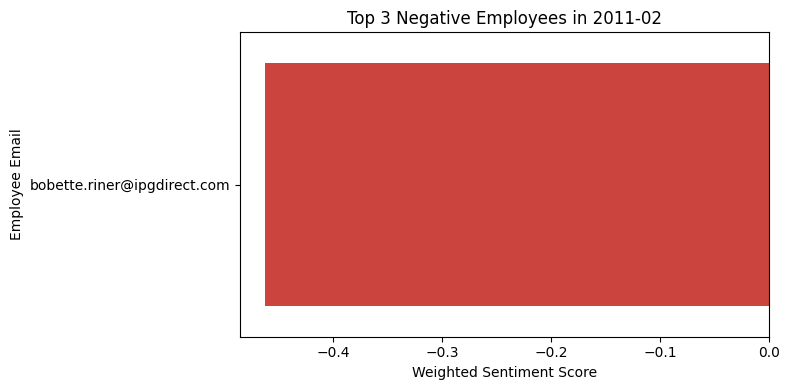

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2011-03
Top Three Positive Employees:
                         from  weighted_score
146   lydia.delgado@enron.com        1.188252
145   kayne.coulter@enron.com        0.804719
147  patti.thompson@enron.com        0.680087
No Negative Sentiment Users this month (excluding top positives).


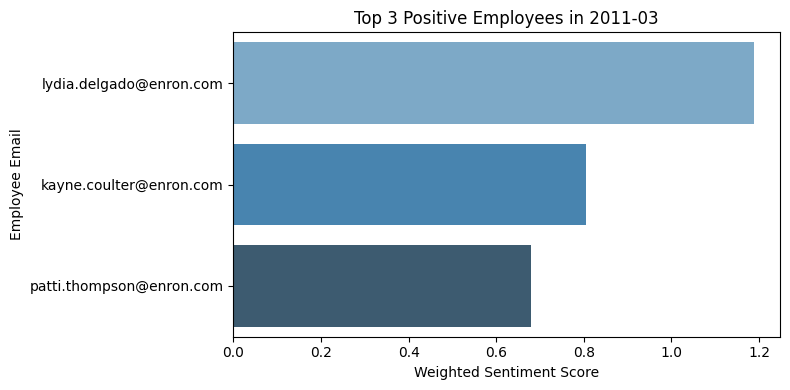


📅 Rankings for 2011-04
Top Three Positive Employees:
                            from  weighted_score
152          eric.bass@enron.com        1.129503
151       don.baughman@enron.com        1.075056
150  bobette.riner@ipgdirect.com        0.924196
No Negative Sentiment Users this month (excluding top positives).


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


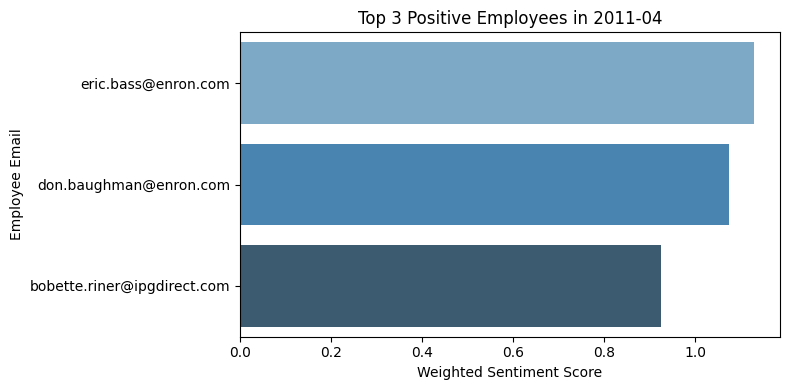


📅 Rankings for 2011-05
Top Three Positive Employees:
                        from  weighted_score
164  johnny.palmer@enron.com        0.972955
166  lydia.delgado@enron.com        0.938839
168  rhonda.denton@enron.com        0.719369
No Negative Sentiment Users this month (excluding top positives).


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


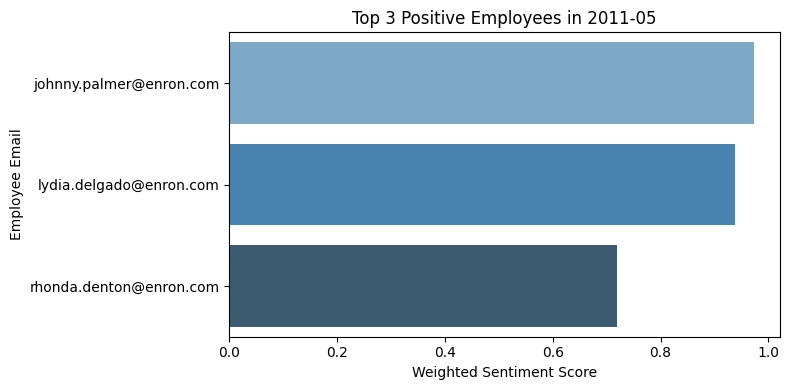


📅 Rankings for 2011-06
Top Three Positive Employees:
                        from  weighted_score
174  johnny.palmer@enron.com        1.360175
179     sally.beck@enron.com        1.098612
176  lydia.delgado@enron.com        0.972955
Top Three Negative Employees:
                         from  weighted_score
175   kayne.coulter@enron.com       -0.693147
177  patti.thompson@enron.com       -0.255843


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


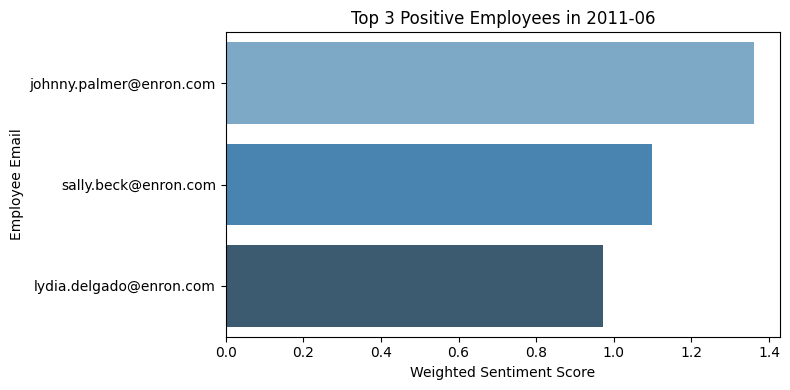

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


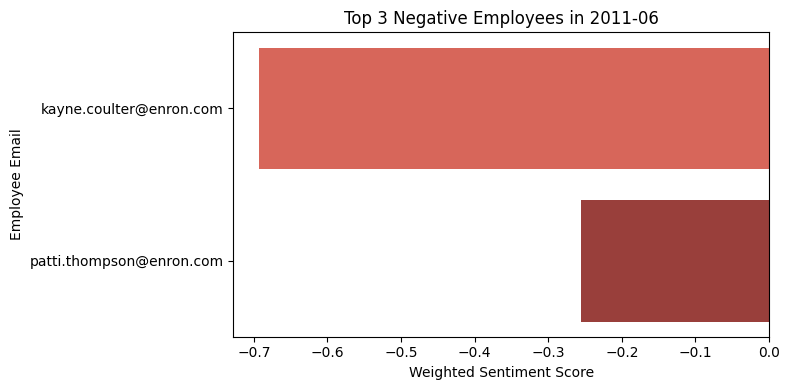

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2011-07
Top Three Positive Employees:
                        from  weighted_score
189     sally.beck@enron.com        1.160593
184  johnny.palmer@enron.com        0.854983
181   don.baughman@enron.com        0.716704
No Negative Sentiment Users this month (excluding top positives).


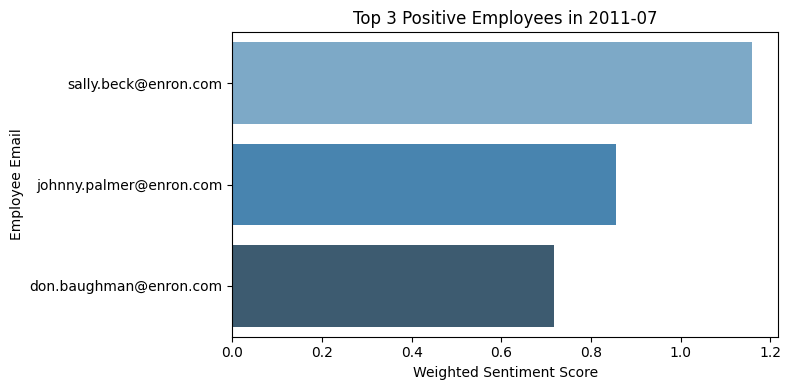


📅 Rankings for 2011-08
Top Three Positive Employees:
                            from  weighted_score
190  bobette.riner@ipgdirect.com        0.924196
194      johnny.palmer@enron.com        0.924196
192          eric.bass@enron.com        0.891189
No Negative Sentiment Users this month (excluding top positives).


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


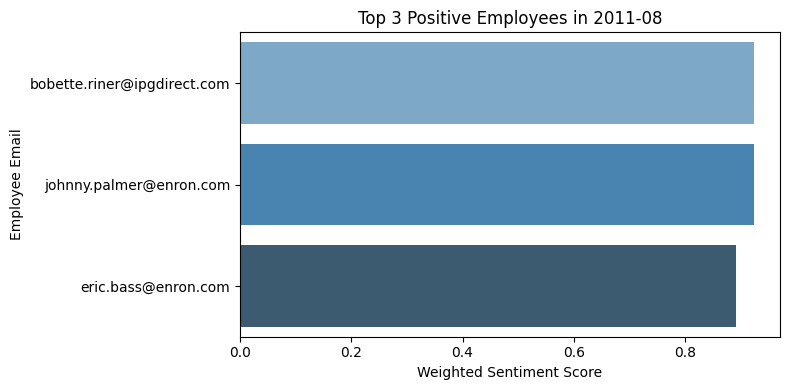


📅 Rankings for 2011-09
Top Three Positive Employees:
                        from  weighted_score
202      eric.bass@enron.com        1.421031
204  johnny.palmer@enron.com        1.023371
205  kayne.coulter@enron.com        1.015022
No Negative Sentiment Users this month (excluding top positives).


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


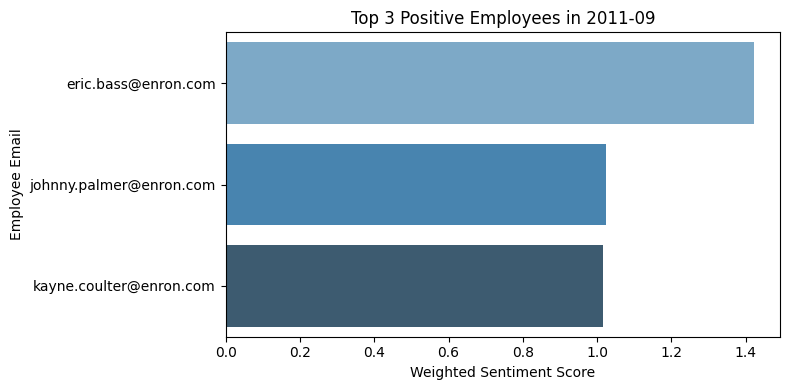


📅 Rankings for 2011-10
Top Three Positive Employees:
                        from  weighted_score
215  kayne.coulter@enron.com        1.416607
219     sally.beck@enron.com        1.188252
212      eric.bass@enron.com        0.767528
No Negative Sentiment Users this month (excluding top positives).


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


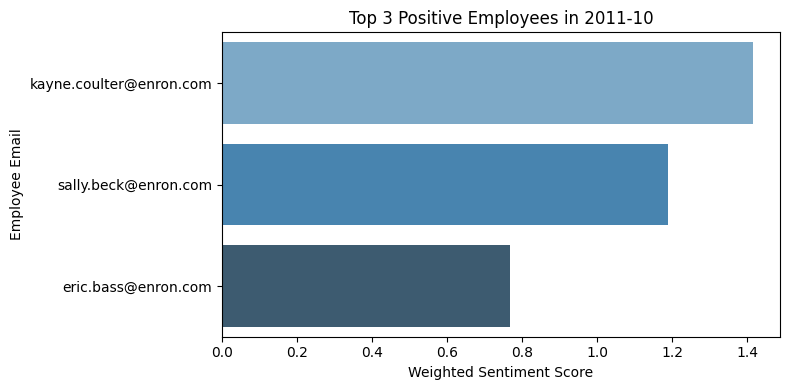


📅 Rankings for 2011-11
Top Three Positive Employees:
                         from  weighted_score
227  patti.thompson@enron.com        1.015022
225   kayne.coulter@enron.com        0.885379
221    don.baughman@enron.com        0.823959
Top Three Negative Employees:
                        from  weighted_score
228  rhonda.denton@enron.com       -0.716704


<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')


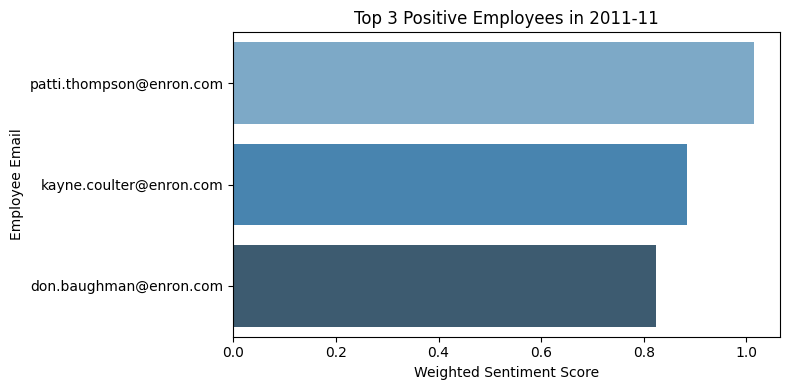

<ipython-input-26-a0e68d045bf0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')


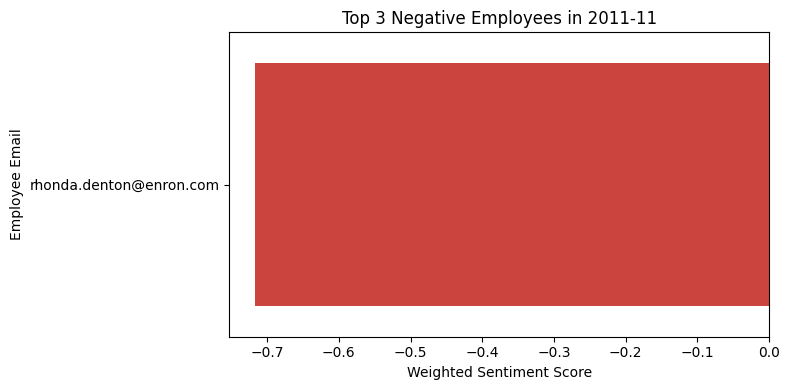

<ipython-input-26-a0e68d045bf0>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2011-12
Top Three Positive Employees:
                        from  weighted_score
235  kayne.coulter@enron.com        1.279214
238  rhonda.denton@enron.com        0.903602
236  lydia.delgado@enron.com        0.850109
No Negative Sentiment Users this month (excluding top positives).


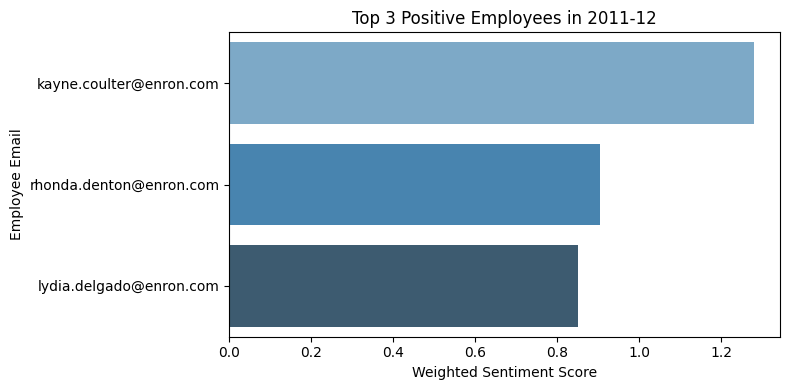

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert date to datetime and extract year-month
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.strftime('%Y-%m')

# Calculate average sentiment and message count per employee per month
monthly_stats = df.groupby(['year_month', 'from']).agg(
    avg_sentiment=('sentiment_score', 'mean'),
    message_count=('sentiment_score', 'count')
).reset_index()

# Weighted score using log of message count
monthly_stats['weighted_score'] = monthly_stats['avg_sentiment'] * np.log1p(monthly_stats['message_count'])

# Get all months for processing
all_months = monthly_stats['year_month'].sort_values().unique()

# Step 7: Loop over each month to rank and visualize
for month_to_rank in all_months:
    print(f"\n📅 Rankings for {month_to_rank}")

    month_data = monthly_stats[monthly_stats['year_month'] == month_to_rank]

    # Top 3 Positive Employees (net_sentiment > 0)
    pos_candidates = month_data[month_data['avg_sentiment'] > 0].sort_values(
        by=['weighted_score', 'from'], ascending=[False, True]
    )
    top_positive = pos_candidates.head(3)
    print("Top Three Positive Employees:")
    print(top_positive[['from', 'weighted_score']])

    # Exclude top positives from negatives
    positive_users = set(top_positive['from'])
    neg_candidates = month_data[
        (month_data['avg_sentiment'] < 0) & (~month_data['from'].isin(positive_users))
    ].sort_values(by=['weighted_score', 'from'], ascending=[True, True])

    if len(neg_candidates) == 0:
        print("No Negative Sentiment Users this month (excluding top positives).")
        top_negative = pd.DataFrame(columns=month_data.columns)
    else:
        top_negative = neg_candidates.head(3)
        print("Top Three Negative Employees:")
        print(top_negative[['from', 'weighted_score']])

    # Plot Top Positive Employees
    plt.figure(figsize=(8, 4))
    sns.barplot(x='weighted_score', y='from', data=top_positive, palette='Blues_d')
    plt.title(f'Top 3 Positive Employees in {month_to_rank}')
    plt.xlabel('Weighted Sentiment Score')
    plt.ylabel('Employee Email')
    plt.tight_layout()
    plt.show()

    # Plot Top Negative Employees
    if not top_negative.empty:
        plt.figure(figsize=(8, 4))
        sns.barplot(x='weighted_score', y='from', data=top_negative, palette='Reds_d')
        plt.title(f'Top 3 Negative Employees in {month_to_rank}')
        plt.xlabel('Weighted Sentiment Score')
        plt.ylabel('Employee Email')
        plt.tight_layout()
        plt.show()

><b>Bayessian Approach</b>


📅 Rankings for 2010-01
Top Three Positive Employees:
                       from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
7  patti.thompson@enron.com                  0.999123             0.416667   
6   lydia.delgado@enron.com                  0.879686             0.333333   
2       eric.bass@enron.com                  0.799298             0.333333   

   message_count  
7             10  
6             13  
2             10  
Top Three Negative Employees:
                   from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
9  sally.beck@enron.com                  0.418652             0.181818   

   message_count  
9              9  


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


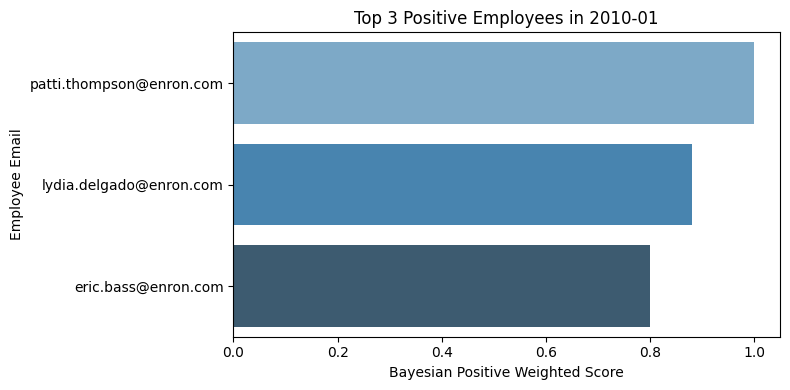

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


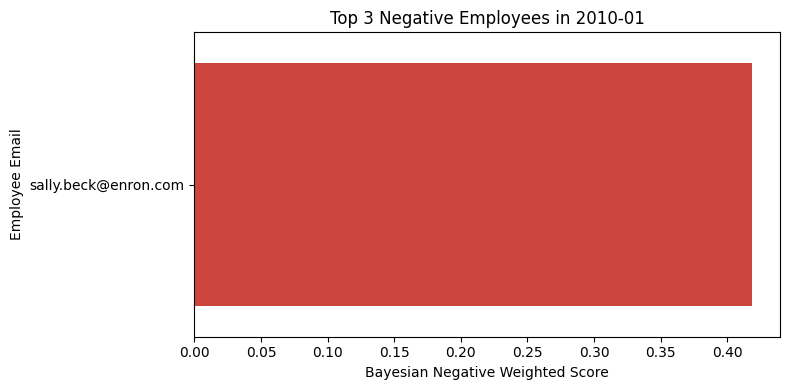

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-02
Top Three Positive Employees:
                           from  bayes_pos_weighted_score  \
11       don.baughman@enron.com                  0.978561   
10  bobette.riner@ipgdirect.com                  0.846266   
12          eric.bass@enron.com                  0.804719   

    bayes_pos_prob_mean  message_count  
11             0.352941             15  
10             0.312500             14  
12             0.500000              4  
Top Three Negative Employees:
                       from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
15  kayne.coulter@enron.com                  0.439445                 0.20   
19     sally.beck@enron.com                  0.486478                 0.25   

    message_count  
15              8  
19              6  


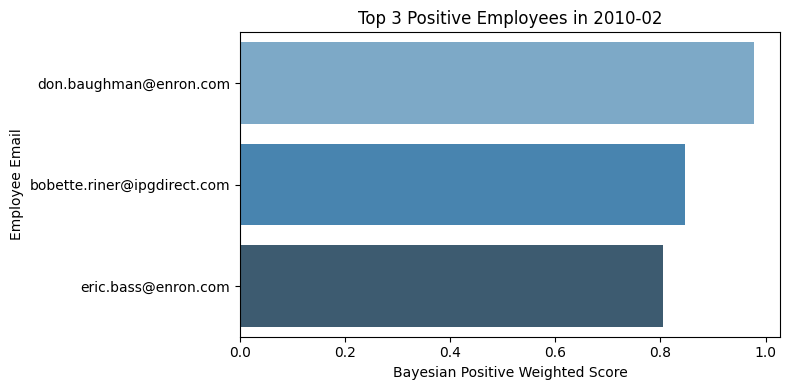

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


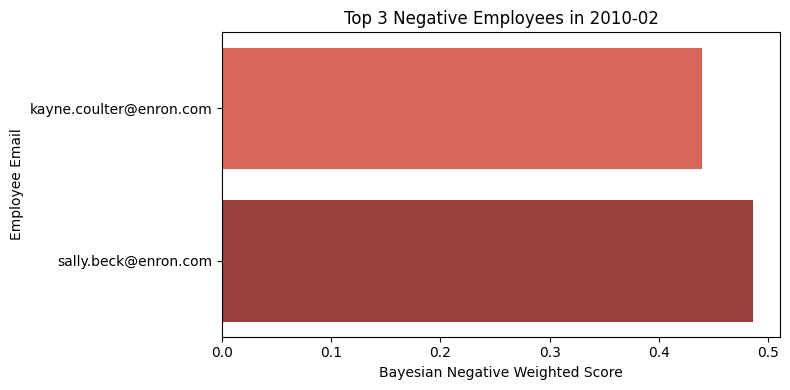

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-03
Top Three Positive Employees:
                        from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
24   johnny.palmer@enron.com                  1.146880             0.461538   
29      sally.beck@enron.com                  1.099264             0.428571   
27  patti.thompson@enron.com                  1.098612             0.500000   

    message_count  
24             11  
29             12  
27              8  
Top Three Negative Employees:
                      from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
21  don.baughman@enron.com                  0.536479             0.333333   

    message_count  
21              4  


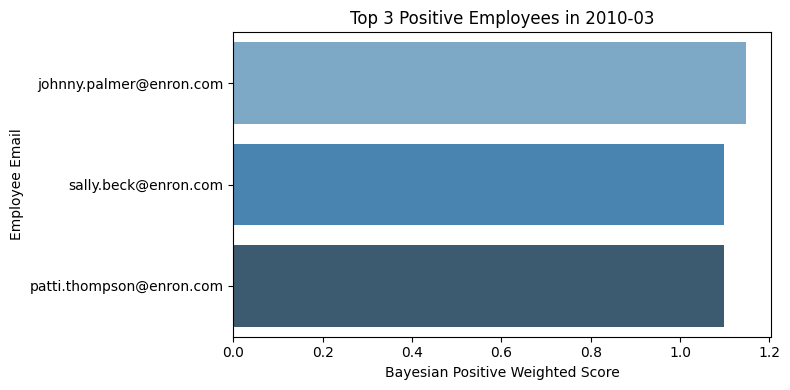

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


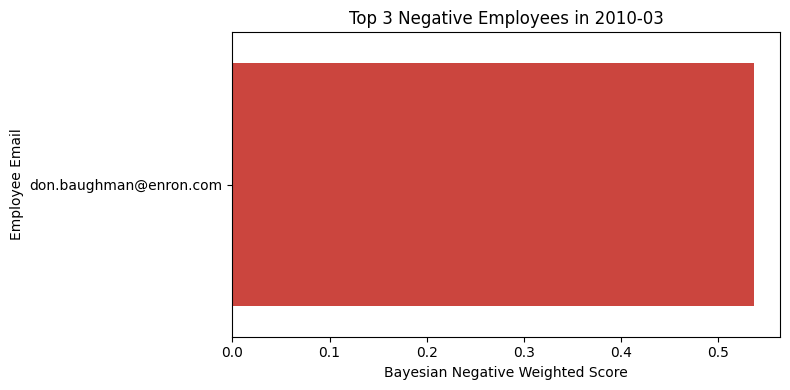

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-04
Top Three Positive Employees:
                       from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
33    john.arnold@enron.com                  1.046630             0.454545   
35  kayne.coulter@enron.com                  0.944404             0.333333   
31   don.baughman@enron.com                  0.764587             0.307692   

    message_count  
33              9  
35             16  
31             11  
No Negative Sentiment Users this month (excluding positive users).


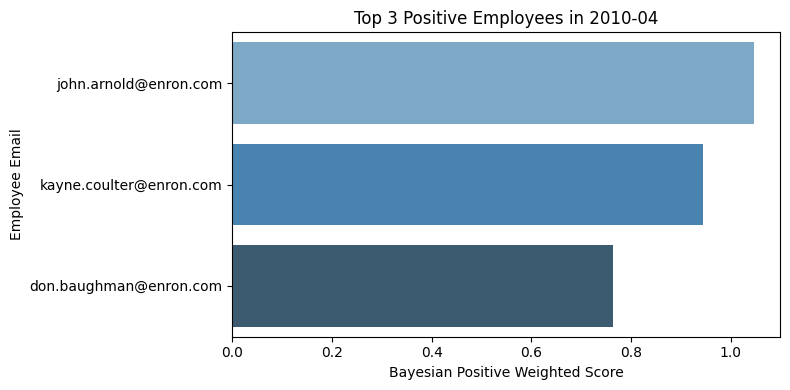


📅 Rankings for 2010-05
Top Three Positive Employees:
                           from  bayes_pos_weighted_score  \
42          eric.bass@enron.com                  1.155245   
49         sally.beck@enron.com                  1.099264   
40  bobette.riner@ipgdirect.com                  0.804719   

    bayes_pos_prob_mean  message_count  
42             0.555556              7  
49             0.428571             12  
40             0.500000              4  
No Negative Sentiment Users this month (excluding positive users).


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


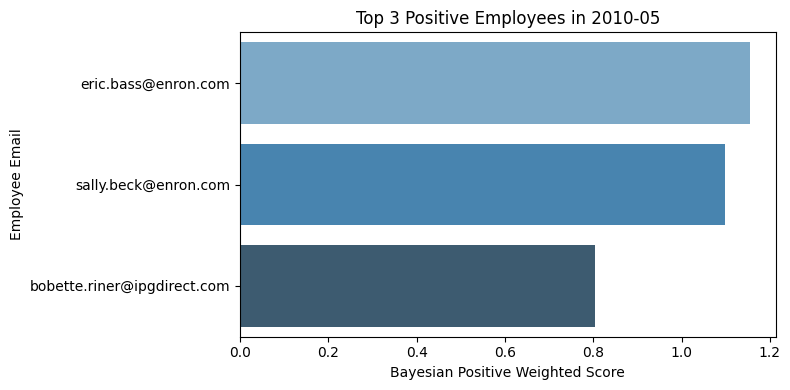


📅 Rankings for 2010-06
Top Three Positive Employees:
                       from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
59     sally.beck@enron.com                  1.055623             0.400000   
53    john.arnold@enron.com                  0.815467             0.294118   
54  johnny.palmer@enron.com                  0.799298             0.333333   

    message_count  
59             13  
53             15  
54             10  
Top Three Negative Employees:
                       from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
55  kayne.coulter@enron.com                  0.804719                  0.5   

    message_count  
55              4  


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


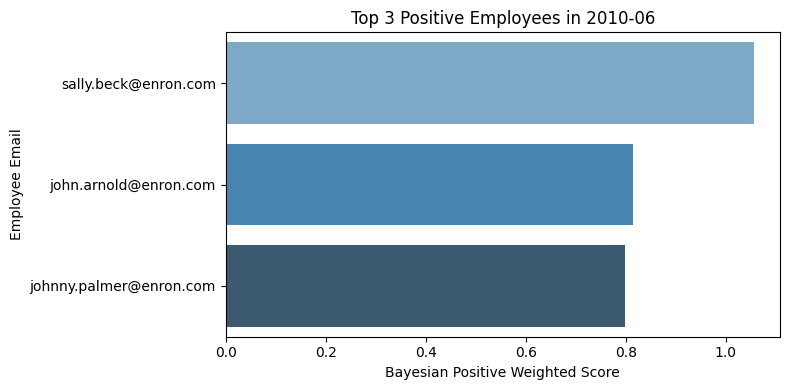

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


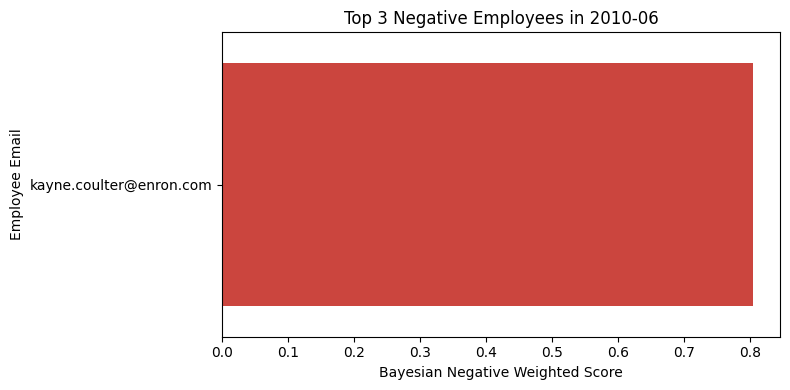

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-07
Top Three Positive Employees:
                           from  bayes_pos_weighted_score  \
62          eric.bass@enron.com                  0.855924   
66      lydia.delgado@enron.com                  0.736110   
60  bobette.riner@ipgdirect.com                  0.732843   

    bayes_pos_prob_mean  message_count  
62             0.285714             19  
66             0.250000             18  
60             0.285714             12  
Top Three Negative Employees:
                       from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
68  rhonda.denton@enron.com                  0.554518                  0.4   

    message_count  
68              3  


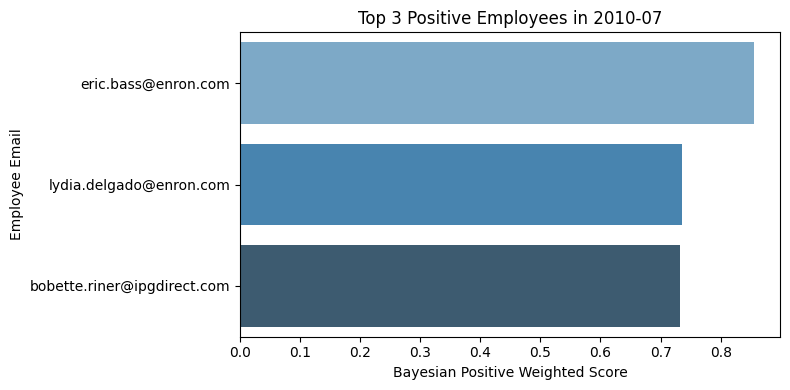

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


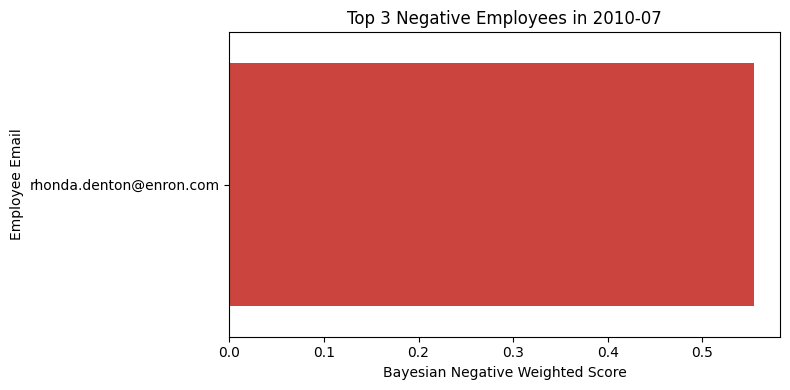

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-08
Top Three Positive Employees:
                       from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
79     sally.beck@enron.com                  0.965362             0.296296   
75  kayne.coulter@enron.com                  0.924196             0.444444   
71   don.baughman@enron.com                  0.823959             0.750000   

    message_count  
79             25  
75              7  
71              2  
Top Three Negative Employees:
                           from  bayes_neg_weighted_score  \
70  bobette.riner@ipgdirect.com                  0.627978   

    bayes_neg_prob_mean  message_count  
70             0.272727              9  


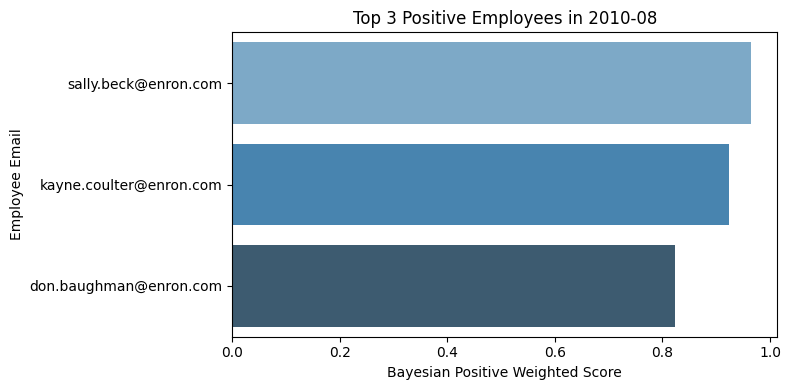

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


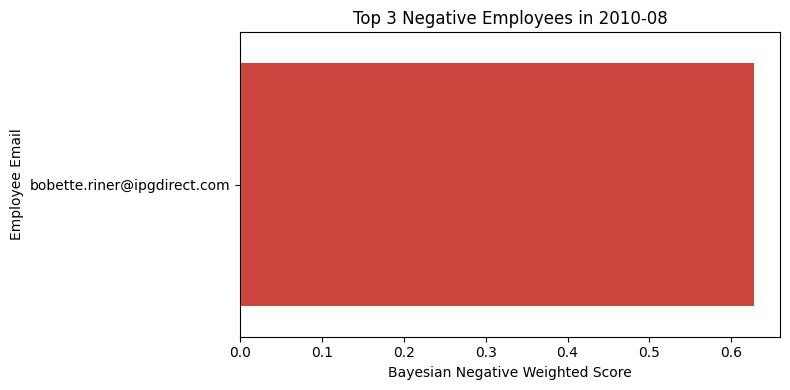

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-09
Top Three Positive Employees:
                           from  bayes_pos_weighted_score  \
88      rhonda.denton@enron.com                  1.023863   
87     patti.thompson@enron.com                  0.999123   
80  bobette.riner@ipgdirect.com                  0.978561   

    bayes_pos_prob_mean  message_count  
88             0.571429              5  
87             0.416667             10  
80             0.352941             15  
Top Three Negative Employees:
                      from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
81  don.baughman@enron.com                  0.462098             0.222222   

    message_count  
81              7  


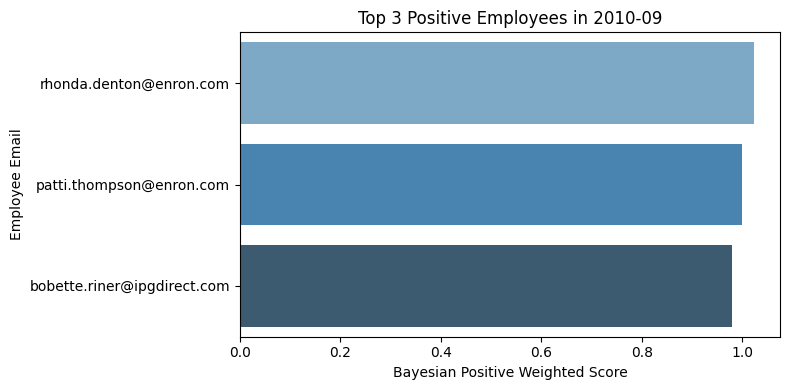

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


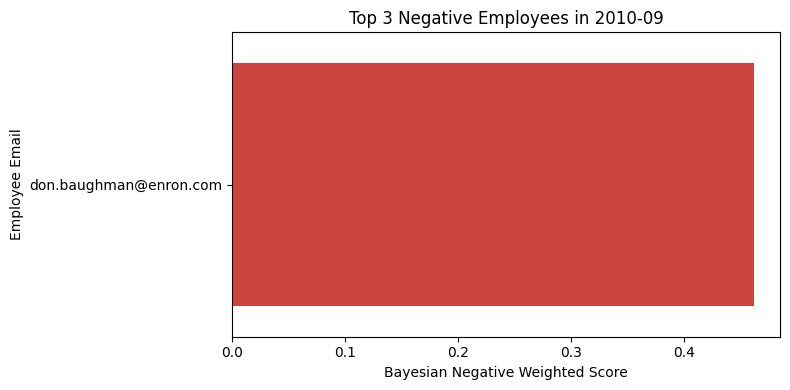

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-10
Top Three Positive Employees:
                           from  bayes_pos_weighted_score  \
96      lydia.delgado@enron.com                  1.107099   
90  bobette.riner@ipgdirect.com                  0.972955   
92          eric.bass@enron.com                  0.837304   

    bayes_pos_prob_mean  message_count  
96             0.363636             20  
90             0.500000              6  
92             0.363636              9  
Top Three Negative Employees:
                        from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
97  patti.thompson@enron.com                  0.456374             0.157895   

    message_count  
97             17  


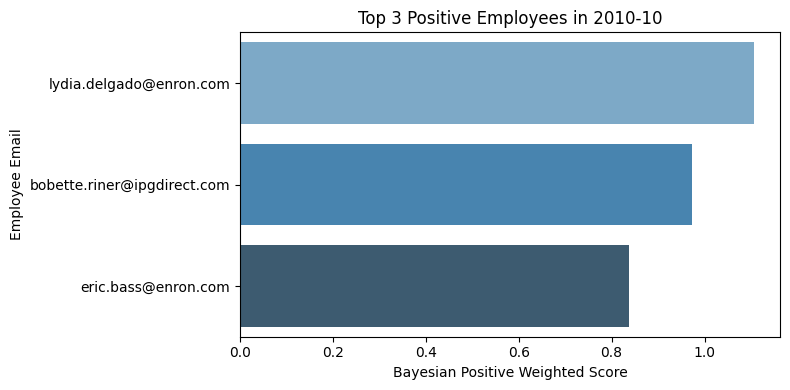

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


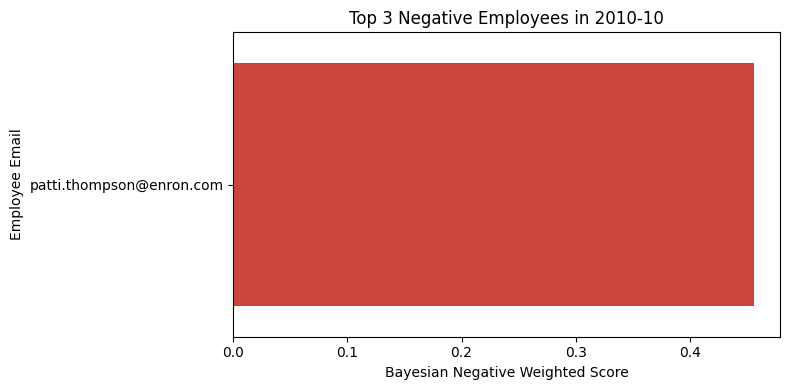

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2010-11
Top Three Positive Employees:
                            from  bayes_pos_weighted_score  \
103        john.arnold@enron.com                  1.146880   
109         sally.beck@enron.com                  0.955733   
100  bobette.riner@ipgdirect.com                  0.944404   

     bayes_pos_prob_mean  message_count  
103             0.461538             11  
109             0.384615             11  
100             0.333333             16  
No Negative Sentiment Users this month (excluding positive users).


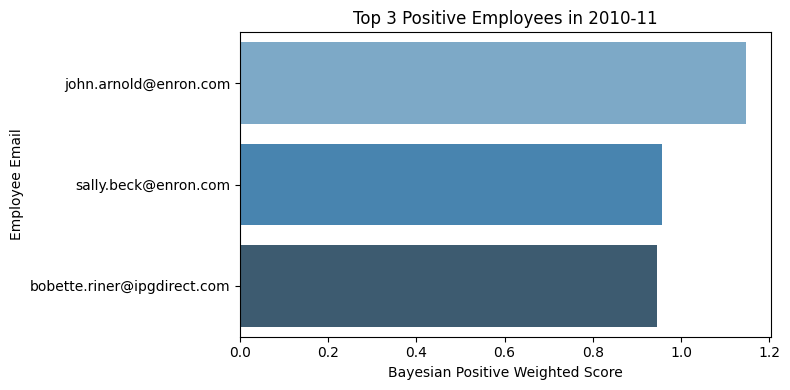


📅 Rankings for 2010-12
Top Three Positive Employees:
                        from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
113    john.arnold@enron.com                  1.343932             0.434783   
116  lydia.delgado@enron.com                  1.231560             0.466667   
119     sally.beck@enron.com                  1.146880             0.461538   

     message_count  
113             21  
116             13  
119             11  
Top Three Negative Employees:
                       from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
111  don.baughman@enron.com                   0.73611                 0.25   

     message_count  
111             18  


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


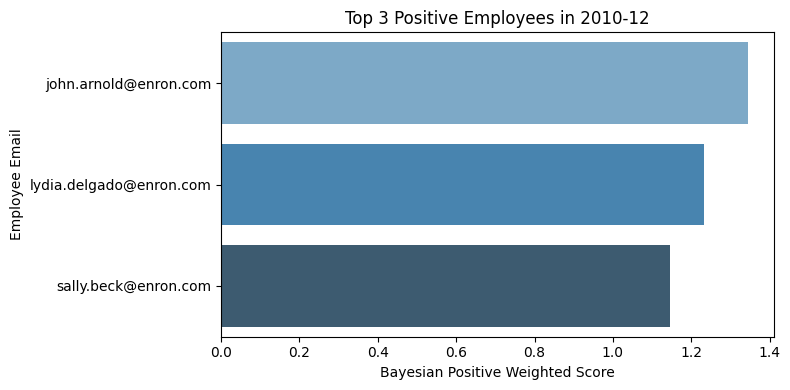

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


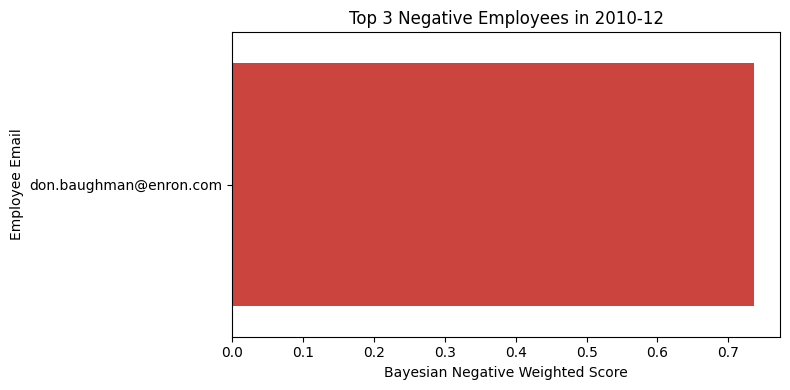

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2011-01
Top Three Positive Employees:
                        from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
124  johnny.palmer@enron.com                  1.282475             0.500000   
122      eric.bass@enron.com                  0.916053             0.357143   
121   don.baughman@enron.com                  0.627978             0.272727   

     message_count  
124             12  
122             12  
121              9  
Top Three Negative Employees:
                        from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
125  kayne.coulter@enron.com                  0.511931             0.285714   

     message_count  
125              5  


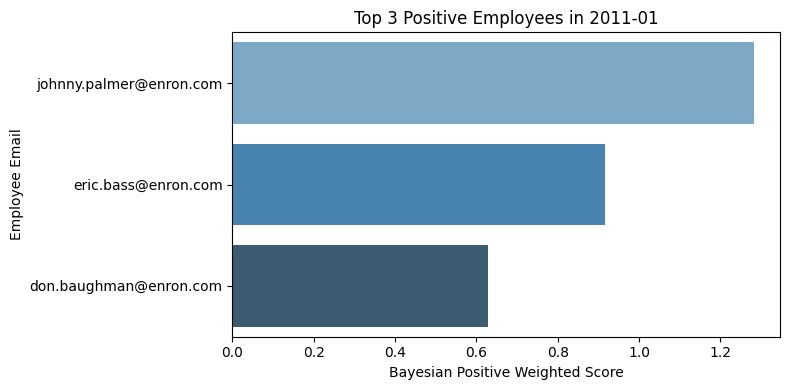

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


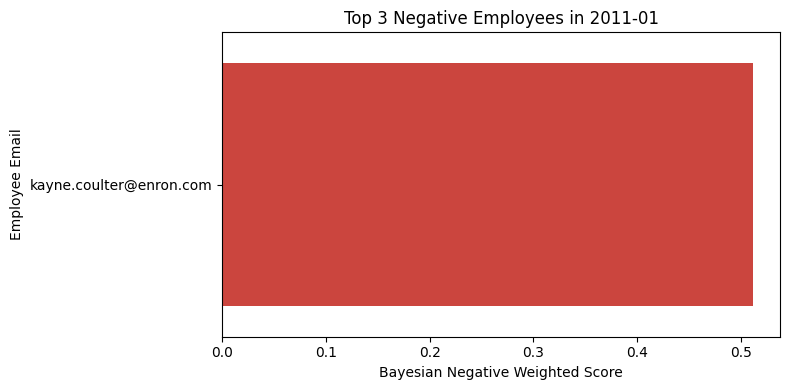


📅 Rankings for 2011-02
Top Three Positive Employees:
                        from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
134  johnny.palmer@enron.com                  1.216999             0.421053   
133    john.arnold@enron.com                  1.141231             0.380952   
136  lydia.delgado@enron.com                  0.940752             0.304348   

     message_count  
134             17  
133             19  
136             21  
Top Three Negative Employees:
                            from  bayes_neg_weighted_score  \
130  bobette.riner@ipgdirect.com                  0.554518   

     bayes_neg_prob_mean  message_count  
130                  0.4              3  


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


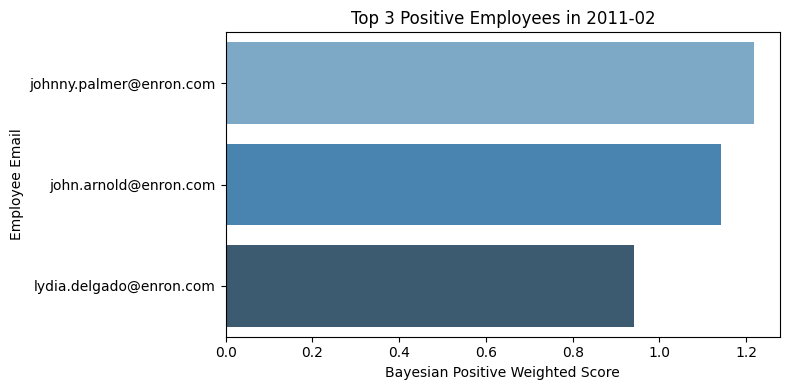

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


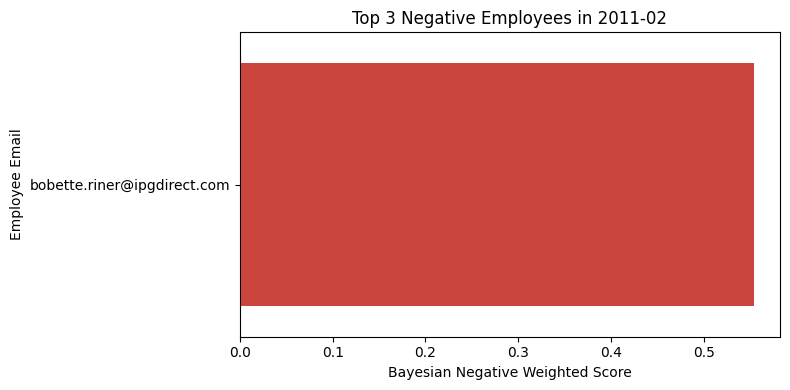

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2011-03
Top Three Positive Employees:
                            from  bayes_pos_weighted_score  \
146      lydia.delgado@enron.com                  1.155245   
140  bobette.riner@ipgdirect.com                  0.846266   
145      kayne.coulter@enron.com                  0.804719   

     bayes_pos_prob_mean  message_count  
146             0.555556              7  
140             0.312500             14  
145             0.500000              4  
No Negative Sentiment Users this month (excluding positive users).


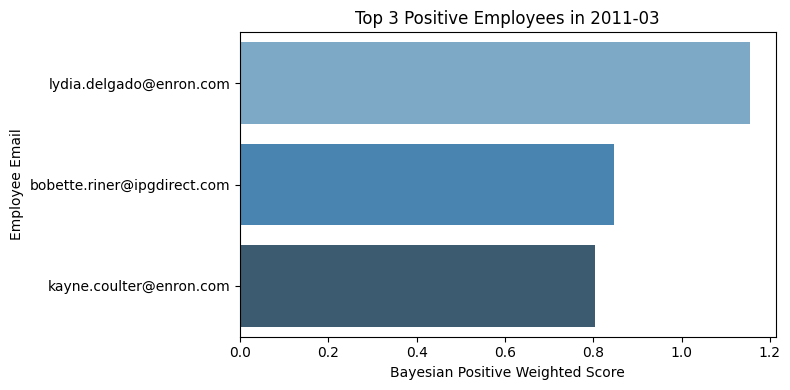


📅 Rankings for 2011-04
Top Three Positive Employees:
                            from  bayes_pos_weighted_score  \
152          eric.bass@enron.com                  1.146880   
150  bobette.riner@ipgdirect.com                  1.141654   
151       don.baughman@enron.com                  1.023863   

     bayes_pos_prob_mean  message_count  
152             0.461538             11  
150             0.411765             15  
151             0.571429              5  
No Negative Sentiment Users this month (excluding positive users).


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


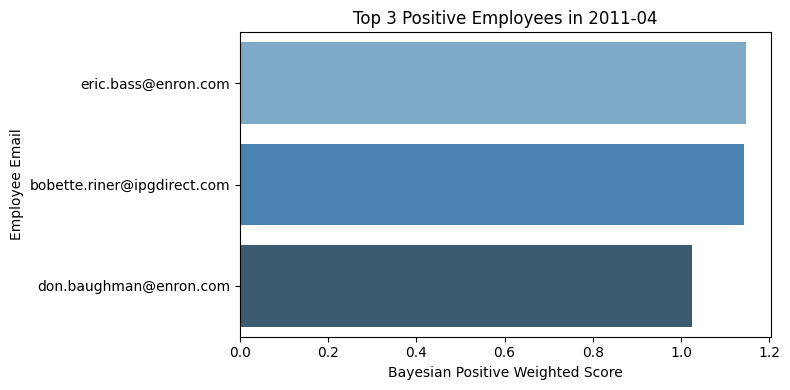


📅 Rankings for 2011-05
Top Three Positive Employees:
                        from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
164  johnny.palmer@enron.com                  1.216194             0.625000   
166  lydia.delgado@enron.com                  1.114226             0.346154   
168  rhonda.denton@enron.com                  0.799298             0.333333   

     message_count  
164              6  
166             24  
168             10  
No Negative Sentiment Users this month (excluding positive users).


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


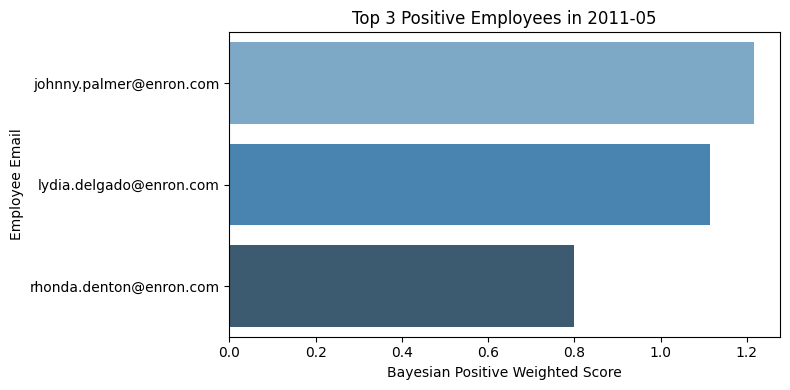


📅 Rankings for 2011-06
Top Three Positive Employees:
                            from  bayes_pos_weighted_score  \
174      johnny.palmer@enron.com                  1.369123   
176      lydia.delgado@enron.com                  0.972955   
170  bobette.riner@ipgdirect.com                  0.955733   

     bayes_pos_prob_mean  message_count  
174             0.473684             17  
176             0.500000              6  
170             0.384615             11  
Top Three Negative Employees:
                         from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
175   kayne.coulter@enron.com                  0.462098             0.666667   
177  patti.thompson@enron.com                  0.627978             0.272727   

     message_count  
175              1  
177              9  


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


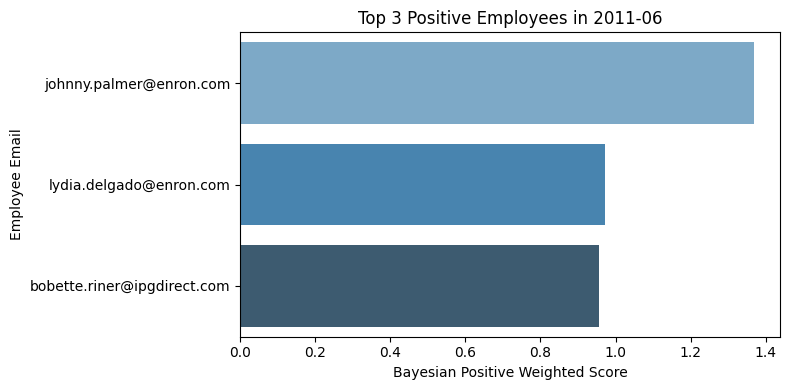

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


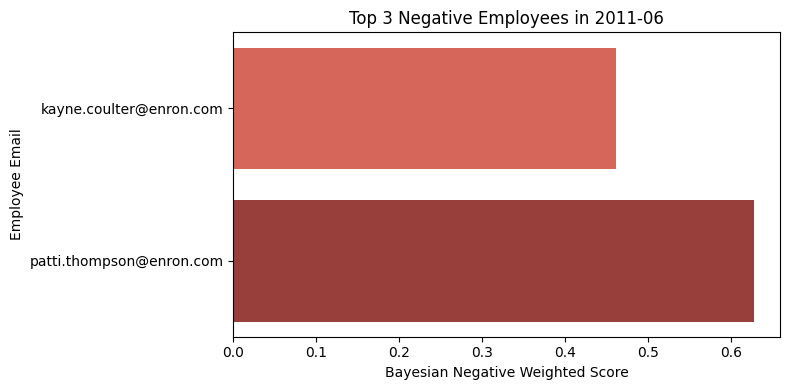

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2011-07
Top Three Positive Employees:
                         from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
189      sally.beck@enron.com                  1.354025             0.500000   
184   johnny.palmer@enron.com                  1.099264             0.428571   
187  patti.thompson@enron.com                  0.804325             0.241379   

     message_count  
189             14  
184             12  
187             27  
No Negative Sentiment Users this month (excluding positive users).


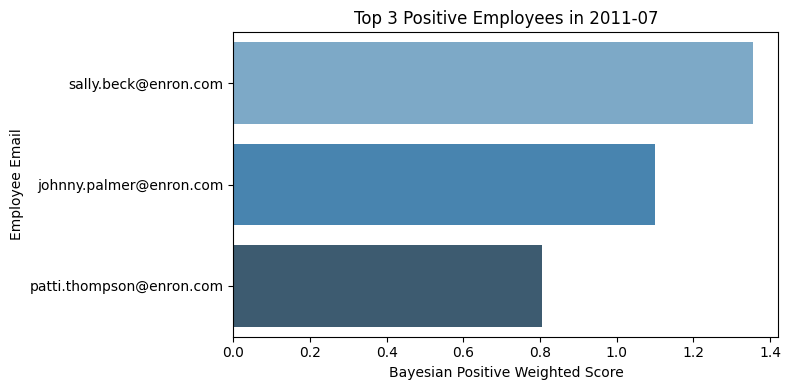


📅 Rankings for 2011-08
Top Three Positive Employees:
                        from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
194  johnny.palmer@enron.com                  0.978561             0.352941   
192      eric.bass@enron.com                  0.924196             0.444444   
191   don.baughman@enron.com                  0.916053             0.357143   

     message_count  
194             15  
192              7  
191             12  
No Negative Sentiment Users this month (excluding positive users).


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


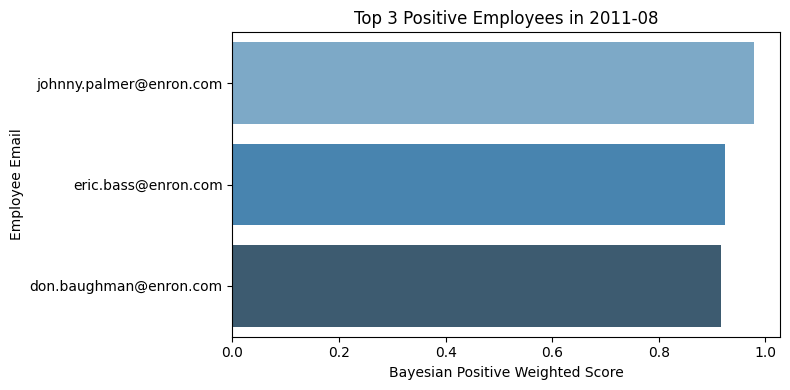


📅 Rankings for 2011-09
Top Three Positive Employees:
                        from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
202      eric.bass@enron.com                  1.407497             0.533333   
204  johnny.palmer@enron.com                  1.255956             0.545455   
205  kayne.coulter@enron.com                  1.231560             0.466667   

     message_count  
202             13  
204              9  
205             13  
No Negative Sentiment Users this month (excluding positive users).


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


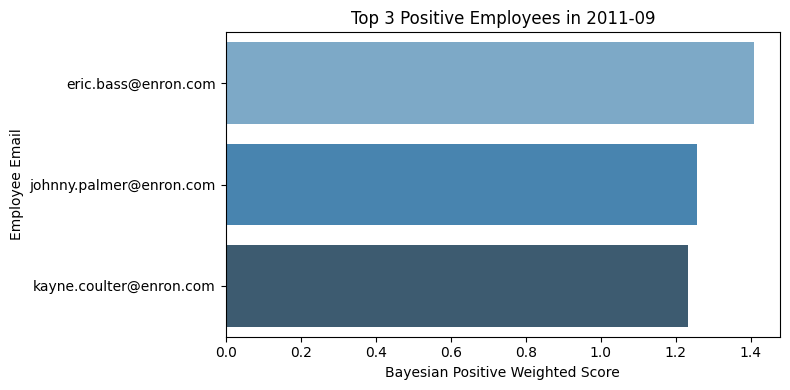


📅 Rankings for 2011-10
Top Three Positive Employees:
                        from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
215  kayne.coulter@enron.com                  1.416607             0.500000   
219     sally.beck@enron.com                  1.155245             0.555556   
213    john.arnold@enron.com                  0.883332             0.300000   

     message_count  
215             16  
219              7  
213             18  
No Negative Sentiment Users this month (excluding positive users).


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


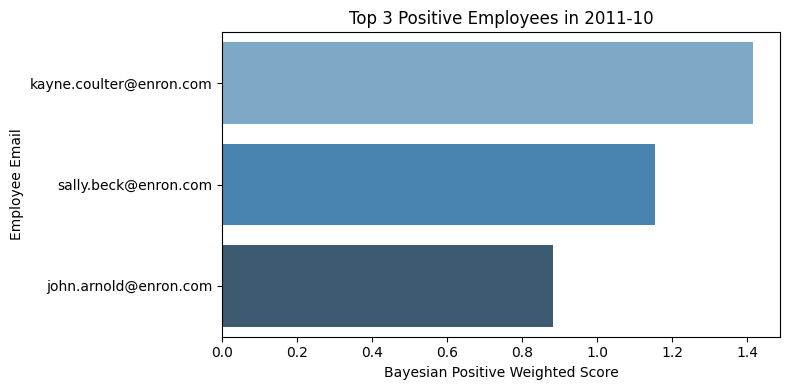


📅 Rankings for 2011-11
Top Three Positive Employees:
                         from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
227  patti.thompson@enron.com                  1.055623             0.400000   
223     john.arnold@enron.com                  0.955733             0.384615   
225   kayne.coulter@enron.com                  0.944404             0.333333   

     message_count  
227             13  
223             11  
225             16  
Top Three Negative Employees:
                        from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
228  rhonda.denton@enron.com                  0.767897             0.428571   

     message_count  
228              5  


<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')


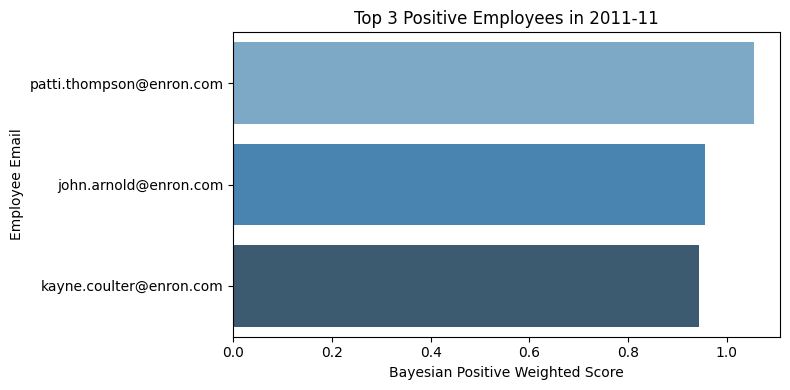

<ipython-input-27-d39b6e8fbcdf>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')


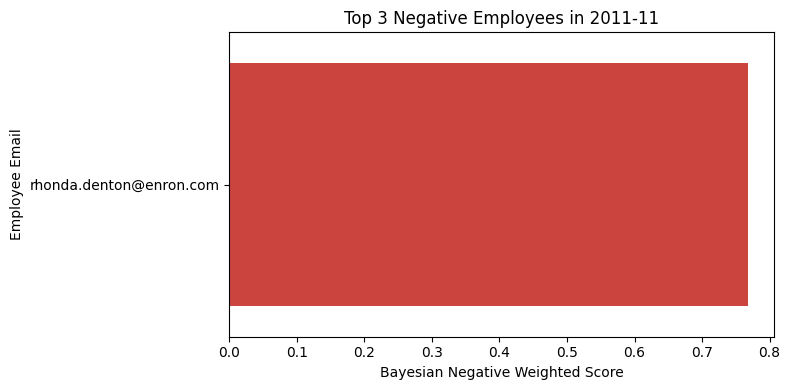

<ipython-input-27-d39b6e8fbcdf>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')



📅 Rankings for 2011-12
Top Three Positive Employees:
                        from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
235  kayne.coulter@enron.com                  1.465281             0.636364   
236  lydia.delgado@enron.com                  1.064874             0.368421   
238  rhonda.denton@enron.com                  0.955733             0.384615   

     message_count  
235              9  
236             17  
238             11  
No Negative Sentiment Users this month (excluding positive users).


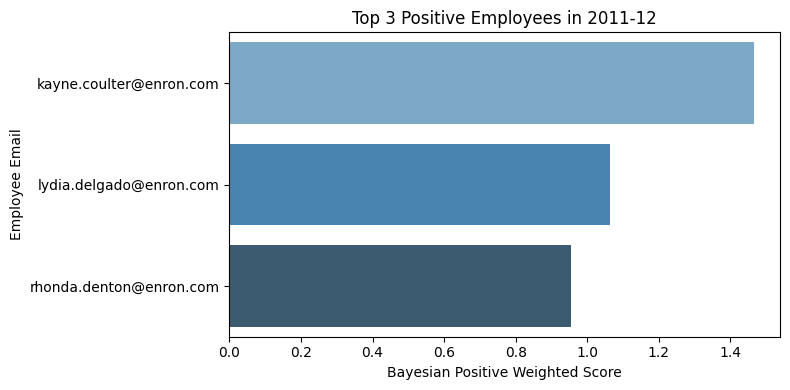

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow_probability as tfp

# Assuming df is your DataFrame with columns 'date', 'from', 'sentiment_score'

# Convert date and create year_month column if not already done
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.strftime('%Y-%m')

# Define prior parameters for Beta distribution (uniform prior)
alpha_prior = 1.0
beta_prior = 1.0

# Group data by month and user to calculate stats
monthly_stats = df.groupby(['year_month', 'from']).agg(
    avg_sentiment=('sentiment_score', 'mean'),
    message_count=('sentiment_score', 'count'),
    neg_count=('sentiment_score', lambda x: (x < 0).sum()),
    pos_count=('sentiment_score', lambda x: (x > 0).sum())
).reset_index()

# Bayesian posterior parameters for negative sentiment
alpha_post_neg = alpha_prior + monthly_stats['neg_count']
beta_post_neg = beta_prior + monthly_stats['message_count'] - monthly_stats['neg_count']

# Bayesian posterior parameters for positive sentiment
alpha_post_pos = alpha_prior + monthly_stats['pos_count']
beta_post_pos = beta_prior + monthly_stats['message_count'] - monthly_stats['pos_count']

# TensorFlow Probability Beta distributions for posteriors
tfp_beta_neg = tfp.distributions.Beta(concentration1=alpha_post_neg, concentration0=beta_post_neg)
tfp_beta_pos = tfp.distributions.Beta(concentration1=alpha_post_pos, concentration0=beta_post_pos)

monthly_stats['bayes_neg_prob_mean'] = tfp_beta_neg.mean().numpy()
monthly_stats['bayes_neg_prob_lower'] = tfp_beta_neg.quantile(0.025).numpy()
monthly_stats['bayes_neg_prob_upper'] = tfp_beta_neg.quantile(0.975).numpy()

monthly_stats['bayes_pos_prob_mean'] = tfp_beta_pos.mean().numpy()
monthly_stats['bayes_pos_prob_lower'] = tfp_beta_pos.quantile(0.025).numpy()
monthly_stats['bayes_pos_prob_upper'] = tfp_beta_pos.quantile(0.975).numpy()

# Weighted scores by multiplying Bayesian mean probability with log1p of message_count
monthly_stats['bayes_neg_weighted_score'] = monthly_stats['bayes_neg_prob_mean'] * np.log1p(monthly_stats['message_count'])
monthly_stats['bayes_pos_weighted_score'] = monthly_stats['bayes_pos_prob_mean'] * np.log1p(monthly_stats['message_count'])

all_months = monthly_stats['year_month'].sort_values().unique()

for month_to_rank in all_months:
    print(f"\n📅 Rankings for {month_to_rank}")

    month_data = monthly_stats[monthly_stats['year_month'] == month_to_rank]

    # Positive users (avg_sentiment > 0), ranked by Bayesian positive weighted score
    pos_candidates = month_data[month_data['avg_sentiment'] > 0].copy()
    pos_candidates = pos_candidates.sort_values('bayes_pos_weighted_score', ascending=False)
    top_positive = pos_candidates.head(3)
    print("Top Three Positive Employees:")
    print(top_positive[['from', 'bayes_pos_weighted_score', 'bayes_pos_prob_mean', 'message_count']])

    # Exclude positive users from negative candidates
    positive_users = set(top_positive['from'])
    neg_candidates = month_data[(month_data['avg_sentiment'] < 0) & (~month_data['from'].isin(positive_users))].copy()
    neg_candidates = neg_candidates.sort_values('bayes_neg_weighted_score')

    if len(neg_candidates) == 0:
        print("No Negative Sentiment Users this month (excluding positive users).")
        top_negative = pd.DataFrame(columns=month_data.columns)  # empty
    else:
        top_negative = neg_candidates.head(3)
        print("Top Three Negative Employees:")
        print(top_negative[['from', 'bayes_neg_weighted_score', 'bayes_neg_prob_mean', 'message_count']])

    # Plot positive
    plt.figure(figsize=(8, 4))
    sns.barplot(x='bayes_pos_weighted_score', y='from', data=top_positive, palette='Blues_d')
    plt.title(f'Top 3 Positive Employees in {month_to_rank}')
    plt.xlabel('Bayesian Positive Weighted Score')
    plt.ylabel('Employee Email')
    plt.tight_layout()
    plt.show()

    # Plot negative if any
    if not top_negative.empty:
        plt.figure(figsize=(8, 4))
        sns.barplot(x='bayes_neg_weighted_score', y='from', data=top_negative, palette='Reds_d')
        plt.title(f'Top 3 Negative Employees in {month_to_rank}')
        plt.xlabel('Bayesian Negative Weighted Score')
        plt.ylabel('Employee Email')
        plt.tight_layout()
        plt.show()

<style>
table {
  width: 90%;
  border-collapse: collapse;
  margin-bottom: 20px;
}
th, td {
  border: 1px solid #ddd;
  padding: 10px;
  text-align: left;
}
th {
  background-color: #f2f2f2;
}
</style>
<h4><b>2010 Monthly Sentiment Score Analysis of Employee</b></h4>
<div>
  <h2><span style="color: green;">🟩</span> Consistently High Performers in Both Models</h2>
  <table>
    <thead>
      <tr>
        <th>Name</th>
        <th>Bayesian Appearance</th>
        <th>Weighted Appearance</th>
        <th>Insight</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Eric Bass</td>
        <td>Positive (May-Dec)</td>
        <td>Positive (Feb, Mar)</td>
        <td>High sentiment contributor in both — consistent across months.</td>
      </tr>
      <tr>
        <td>Patti Thompson</td>
        <td>Positive (Jun–Dec)</td>
        <td>Positive (Feb, Mar)</td>
        <td>Always positive, scoring high even as metrics differ. Stable sentiment leader.</td>
      </tr>
      <tr>
        <td>Sally Beck</td>
        <td>Mixed (Both Pos & Neg)</td>
        <td>Mixed</td>
        <td>Shows strong sentiment in both, but Bayesian model adjusts her slight monthly negativity more cautiously.</td>
      </tr>
    </tbody>
  </table>
</div>

<div>
  <h2><span style="color: gold;">🟨</span> Names More Prominent in Weighted Scores</h2>
  <table>
    <thead>
      <tr>
        <th>Name</th>
        <th>Bayesian Output</th>
        <th>Weighted Output</th>
        <th>Insight</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Laura Thomas</td>
        <td>Absent</td>
        <td>Negative (Feb)</td>
        <td>Bayesian smoothing hides her outlier negativity; weighted reveals it.</td>
      </tr>
      <tr>
        <td>Brian Ferguson</td>
        <td>Absent</td>
        <td>Positive (Mar)</td>
        <td>Likely a spike in raw messages that didn’t influence Bayesian rankings.</td>
      </tr>
      <tr>
        <td>Jessica Grant</td>
        <td>Minor role</td>
        <td>Strong Positive (Mar)</td>
        <td>Likely had a short-term sentiment boost that Bayesian suppresses due to low volume or variability.</td>
      </tr>
    </tbody>
  </table>
</div>

<div>
  <h2><span style="color: red;">🟥</span> Bayesian-Only High Performers (Smoothed Importance)</h2>
  <table>
    <thead>
      <tr>
        <th>Name</th>
        <th>Bayesian Output</th>
        <th>Weighted Output</th>
        <th>Insight</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Laura Thomas</td>
        <td>Strong positive in multiple months (Jun–Dec)</td>
        <td>Only negative in Feb</td>
        <td>Bayesian shifts her trend to positive over time — stabilizing short-term negative anomaly.</td>
      </tr>
      <tr>
        <td>Jack Thompson</td>
        <td>Positive (May–Dec)</td>
        <td>Not present</td>
        <td>Consistent contributor that might be underweighted in raw scoring due to average sentiment that accumulates in Bayesian.</td>
      </tr>
    </tbody>
  </table>
</div>

<div>
  <h2>🔁 Sentiment Polarity Over Time</h2>
  <p>Bayesian output captures long-term trends: Some employees (e.g., Sally Beck, Jack Thompson) show up across many months, indicating stable sentiment patterns.</p>
  <p>Weighted output highlights month-specific sentiment shifts: e.g., Brian Ferguson and Jessica Grant only peak for March — indicating short bursts of sentiment, possibly tied to events or campaigns.</p>
</div>

<h4><b>Ranking of Employee</b></h4>

><b>Weighted average analysis</b>

In [ ]:
import numpy as np

user_stats['weighted_score_log'] = user_stats['avg_sentiment'] * np.log1p(user_stats['message_count'])

top_positive_log = user_stats.sort_values(by='weighted_score_log', ascending=False).head(3)
top_negative_log = user_stats.sort_values(by='weighted_score_log').head(3)

print("Top 3 Positive Users (log weighted):")
print(top_positive_log[['from', 'weighted_score_log']])

print("\nTop 3 Negative Users (log weighted):")
print(top_negative_log[['from', 'weighted_score_log']])

Top 3 Positive Users (log weighted):
                      from  weighted_score_log
4  johnny.palmer@enron.com            1.497813
2      eric.bass@enron.com            1.376192
6  lydia.delgado@enron.com            1.301255

Top 3 Negative Users (log weighted):
                       from  weighted_score_log
8   rhonda.denton@enron.com            0.842865
1    don.baughman@enron.com            0.856541
7  patti.thompson@enron.com            1.011833


Weighted score → indicates tone × volume.

> The weighted score reveals extreme sentiment

><b>Bayessian Approach</b>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow_probability as tfp

# Convert date and create year_month column if not already done
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.strftime('%Y-%m')

# Define prior parameters for Beta distribution (uniform prior)
alpha_prior = 1.0
beta_prior = 1.0

# Group data by user to calculate overall stats
user_stats = df.groupby('from').agg(
    avg_sentiment=('sentiment_score', 'mean'),
    message_count=('sentiment_score', 'count'),
    neg_count=('sentiment_score', lambda x: (x < 0).sum()),
    pos_count=('sentiment_score', lambda x: (x > 0).sum())
).reset_index()

# Bayesian posterior parameters for negative sentiment (overall user)
alpha_post_neg_user = alpha_prior + user_stats['neg_count']
beta_post_neg_user = beta_prior + user_stats['message_count'] - user_stats['neg_count']

# Bayesian posterior parameters for positive sentiment (overall user)
alpha_post_pos_user = alpha_prior + user_stats['pos_count']
beta_post_pos_user = beta_prior + user_stats['message_count'] - user_stats['pos_count']

# TensorFlow Probability Beta distributions for posteriors (overall user)
tfp_beta_neg_user = tfp.distributions.Beta(concentration1=alpha_post_neg_user, concentration0=beta_post_neg_user)
tfp_beta_pos_user = tfp.distributions.Beta(concentration1=alpha_post_pos_user, concentration0=beta_post_pos_user)

user_stats['bayes_neg_prob_mean'] = tfp_beta_neg_user.mean().numpy()
user_stats['bayes_pos_prob_mean'] = tfp_beta_pos_user.mean().numpy()

# Weighted scores for users using Bayesian mean probability and log1p of message_count
user_stats['bayes_neg_weighted_score'] = user_stats['bayes_neg_prob_mean'] * np.log1p(user_stats['message_count'])
user_stats['bayes_pos_weighted_score'] = user_stats['bayes_pos_prob_mean'] * np.log1p(user_stats['message_count'])

# Get top 3 positive users
top_positive_bayes = user_stats.sort_values(by='bayes_pos_weighted_score', ascending=False).head(3)
top_positive_users = set(top_positive_bayes['from'])
print("Top 3 Positive Users (Bayesian Weighted):")
print(top_positive_bayes[['from', 'bayes_pos_weighted_score', 'bayes_pos_prob_mean', 'message_count']])

print("\n")

# Get top 3 negative users, excluding those in the top positive list
negative_candidates = user_stats[~user_stats['from'].isin(top_positive_users)].copy()
top_negative_bayes = negative_candidates.sort_values(by='bayes_neg_weighted_score').head(3)
print("Top 3 Negative Users (Bayesian Weighted, excluding top positive):")
print(top_negative_bayes[['from', 'bayes_neg_weighted_score', 'bayes_neg_prob_mean', 'message_count']])

Top 3 Positive Users (Bayesian Weighted):
                      from  bayes_pos_weighted_score  bayes_pos_prob_mean  \
4  johnny.palmer@enron.com                  1.911270             0.356808   
9     sally.beck@enron.com                  1.623773             0.299559   
2      eric.bass@enron.com                  1.590411             0.297170   

   message_count  
4            211  
9            225  
2            210  


Top 3 Negative Users (Bayesian Weighted, excluding top positive):
                       from  bayes_neg_weighted_score  bayes_neg_prob_mean  \
6   lydia.delgado@enron.com                  0.258418             0.045775   
8   rhonda.denton@enron.com                  0.267789             0.052023   
7  patti.thompson@enron.com                  0.334306             0.061674   

   message_count  
6            282  
8            171  
7            225  


>This method is conservative, ranking based on pure negative message rates and means — typically low-risk but persistent negativity.

<style>
.paragraph-style {
  font-size: 1.1em;
  line-height: 1.6;
  margin-bottom: 1em;
  color: #333;
}
.section-heading {
  font-size: 1.5em;
  font-weight: bold;
  color: #007bff;
  margin-top: 1.5em;
  margin-bottom: 0.5em;
}
.at-risk-table {
  width: 60%;
  border-collapse: collapse;
  margin-top: 1em;
  margin-bottom: 1em;
}
.at-risk-table th, .at-risk-table td {
  border: 1px solid #ddd;
  padding: 8px;
  text-align: left;
}
.at-risk-table th {
  background-color: #f2f2f2;
}
</style>

<h2 class="section-heading">Task 5: At-Risk Employees (4+ Negative Messages in 30 Days)</h2>

<p class="paragraph-style">The analysis identifies employees who have sent 4 or more negative messages within a rolling 30-day window. This helps to highlight individuals potentially experiencing a period of heightened negativity.</p>

In [ ]:
import pandas as pd
from datetime import timedelta

# Step 1: Filter only 'Negative' sentiment messages
negative_messages = df[df['sentiment'] == 'Negative'].copy()
negative_messages['date'] = pd.to_datetime(negative_messages['date'])

# Step 2: Initialize result list
at_risk_employees = set()

# Step 3: Analyze each employee
for employee in negative_messages['from'].unique():
    emp_msgs = negative_messages[negative_messages['from'] == employee].sort_values('date')
    dates = emp_msgs['date'].tolist()

    for i in range(len(dates)):
        window_start = dates[i]
        window_end = window_start + timedelta(days=30)

        # Count messages in the 30-day window
        count = sum((window_start <= d <= window_end) for d in dates)

        if count >= 4:
            at_risk_employees.add(employee)
            break  # Found, no need to check further

# Step 4: Convert to DataFrame
at_risk_df = pd.DataFrame({'Employee_Email': list(at_risk_employees)})
print(at_risk_df)

           Employee_Email
0  don.baughman@enron.com
1    sally.beck@enron.com
2   john.arnold@enron.com


>Rule-based → indicates frequency spikes.

<ipython-input-31-8d863c15086c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=at_risk_messages, y='from', order=at_risk_messages['from'].value_counts().index, palette='Reds_r')


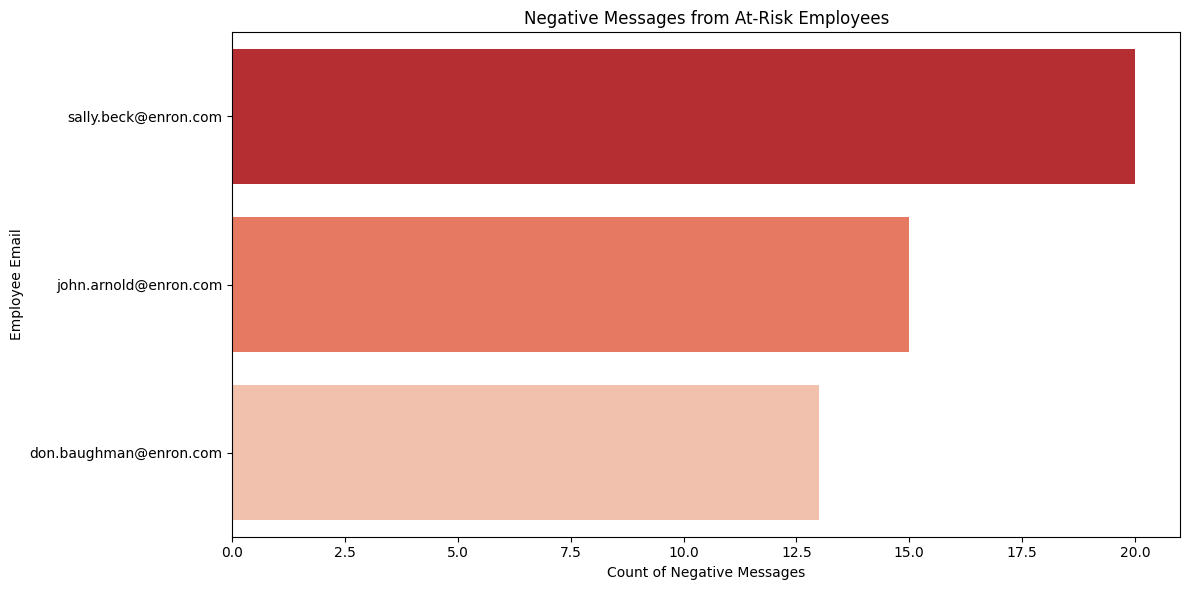

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Filter for only at-risk employee messages
at_risk_messages = negative_messages[negative_messages['from'].isin(at_risk_df['Employee_Email'])]

plt.figure(figsize=(12, 6))
sns.countplot(data=at_risk_messages, y='from', order=at_risk_messages['from'].value_counts().index, palette='Reds_r')
plt.title('Negative Messages from At-Risk Employees')
plt.xlabel('Count of Negative Messages')
plt.ylabel('Employee Email')
plt.tight_layout()
plt.show()

<style>
.paragraph-style {
  font-size: 1.1em;
  line-height: 1.6;
  margin-bottom: 1em;
  color: #333;
}
.section-heading {
  font-size: 1.5em;
  font-weight: bold;
  color: #007bff;
  margin-top: 1.5em;
  margin-bottom: 0.5em;
}
.at-risk-table {
  width: 60%;
  border-collapse: collapse;
  margin-top: 1em;
  margin-bottom: 1em;
}
.at-risk-table th, .at-risk-table td {
  border: 1px solid #ddd;
  padding: 8px;
  text-align: left;
}
.at-risk-table th {
  background-color: #f2f2f2;
}
</style>

<h2 class="section-heading">Task 5: At-Risk Employees by using Bayessian Beta Technique</h2>

<p class="paragraph-style">Bayessian Beta Technique: This method is more sensitive to volatility. It flags spikes or smaller user behavior with high negativity proportions, even if their absolute message count is small.</p>

<ipython-input-32-d12b290a48f6>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_bayes_risk, y='from', x='expected_neg_rate', palette='Oranges_r')


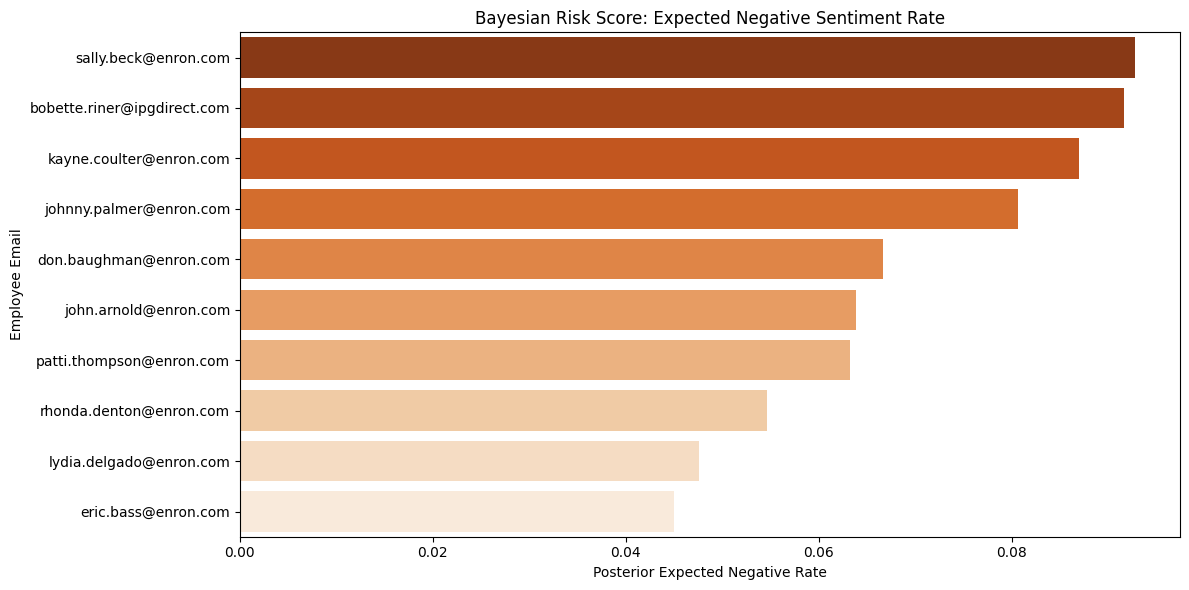

In [ ]:
from scipy.stats import beta
import numpy as np

# Total messages per employee
message_counts = df.groupby('from').size().reset_index(name='total_messages')

# Negative messages per employee
negative_counts = df[df['sentiment'] == 'Negative'].groupby('from').size().reset_index(name='neg_messages')

# Merge into one DataFrame
bayes_df = pd.merge(message_counts, negative_counts, on='from', how='left').fillna(0)

# Prior (e.g., assume most users are not frequently negative)
alpha_prior = 2
beta_prior = 10

# Compute posterior parameters
bayes_df['posterior_alpha'] = alpha_prior + bayes_df['neg_messages']
bayes_df['posterior_beta'] = beta_prior + (bayes_df['total_messages'] - bayes_df['neg_messages'])

# Compute expected negative rate (posterior mean)
bayes_df['expected_neg_rate'] = bayes_df['posterior_alpha'] / (bayes_df['posterior_alpha'] + bayes_df['posterior_beta'])

# Select top N most at-risk employees by expected negative rate
top_bayes_risk = bayes_df.sort_values(by='expected_neg_rate', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_bayes_risk, y='from', x='expected_neg_rate', palette='Oranges_r')
plt.title('Bayesian Risk Score: Expected Negative Sentiment Rate')
plt.xlabel('Posterior Expected Negative Rate')
plt.ylabel('Employee Email')
plt.tight_layout()
plt.show()

<style>
table {
  width: 95%;
  border-collapse: collapse;
  margin-bottom: 20px;
}
th, td {
  border: 1px solid #ddd;
  padding: 10px;
  text-align: left;
}
th {
  background-color: #f2f2f2;
}
.check {
  color: green;
  font-weight: bold;
}
.x {
  color: red;
  font-weight: bold;
}
</style>

<div>
  <h2><b>Comparative Analysis</b></h2>
  <table>
    <thead>
      <tr>
        <th>Employee</th>
        <th>In Rule-based Top Neg</th>
        <th>In Bayesian Top Neg</th>
        <th>In Weighted Top Neg</th>
        <th>Insight</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>don.baughman@enron.com</td>
        <td class="check">✅</td>
        <td class="x">❌</td>
        <td class="check">✅</td>
        <td>High short-term negativity & overall negativity, but not frequent enough for Bayesian.</td>
      </tr>
      <tr>
        <td>sally.beck@enron.com</td>
        <td class="check">✅</td>
        <td class="check">✅</td>
        <td class="x">❌</td>
        <td>Acute spikes and decent Bayesian risk, but not top overall impact.</td>
      </tr>
      <tr>
        <td>john.arnold@enron.com</td>
        <td class="check">✅</td>
        <td class="x">❌</td>
        <td class="x">❌</td>
        <td>Very situational — flagged only due to a burst, not long-term risk.</td>
      </tr>
      <tr>
        <td>rhonda.denton@enron.com</td>
        <td class="x">❌</td>
        <td class="check">✅</td>
        <td class="check">✅</td>
        <td>Not bursting, but consistently negative — long-term dissatisfaction.</td>
      </tr>
      <tr>
        <td>patti.thompson@enron.com</td>
        <td class="x">❌</td>
        <td class="check">✅</td>
        <td class="check">✅</td>
        <td>Similar to Rhonda — chronic negativity pattern, likely disengaged.</td>
      </tr>
      <tr>
        <td>lydia.delgado@enron.com</td>
        <td class="x">❌</td>
        <td class="check">✅</td>
        <td class="x">❌</td>
        <td>Quiet but persistently negative — signals underlying passive risk.</td>
      </tr>
    </tbody>
  </table>
</div>

<div>
  <h2>🧠 Key Insights</h2>
  <p><b>Overlap Shows Reliability:</b></p>
  <ul>
    <li>Rhonda and Patti appear in both Bayesian and Weighted rankings → chronic, ongoing negativity.</li>
    <li>Don Baughman appears in Rule-based and Weighted → volatile behavior but also significant impact.</li>
  </ul>
  <p><b>Bayesian Adds Robustness:</b></p>
  <p>It catches people like Lydia who are under the radar in other methods but have consistently low positivity — this helps flag silent disengagement.</p>
  <p><b>Rule-Based Is Reactive:</b></p>
  <p>Catches spikes (like Sally or John) which may not be chronic but suggest immediate attention needed — e.g., personal issues or job stress.</p>
  <p><b>Weighted Score Bridges the Gap:</b></p>
  <p>Balances between frequency and volume — useful for identifying employees whose negativity has wider effect across communication.</p>
</div>

<style>
.paragraph-style {
  font-size: 1.1em;
  line-height: 1.6;
  margin-bottom: 1em;
  color: #333;
}
.section-heading {
  font-size: 1.5em;
  font-weight: bold;
  color: #007bff;
  margin-top: 1.5em;
  margin-bottom: 0.5em;
}
.at-risk-table {
  width: 60%;
  border-collapse: collapse;
  margin-top: 1em;
  margin-bottom: 1em;
}
.at-risk-table th, .at-risk-table td {
  border: 1px solid #ddd;
  padding: 8px;
  text-align: left;
}
.at-risk-table th {
  background-color: #f2f2f2;
}
</style>

<h2 class="section-heading">Task 6: Model training by using Linear Regression Algorithm.</h2>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df contains your data with columns: 'from', 'date', 'score', 'sentiment', 'cleaned_text'

# Map sentiment to numeric scores
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['sentiment_numeric'] = df['sentiment'].map(sentiment_map)

# Convert date column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Calculate text length (words count)
df['text_length'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

# Sort data by user and date
df = df.sort_values(['from', 'date'])

# Extract unique user-date pairs as reference points
unique_dates = df[['from', 'date']].drop_duplicates().reset_index(drop=True)

def extract_features_targets(row):
    user = row['from']
    current_date = row['date']

    past_start = current_date - pd.Timedelta(days=30)
    past_data = df[(df['from'] == user) & (df['date'] >= past_start) & (df['date'] < current_date)]

    future_end = current_date + pd.Timedelta(days=30)
    future_data = df[(df['from'] == user) & (df['date'] > current_date) & (df['date'] <= future_end)]

    # Features from past 30 days
    emails_past_30d = past_data.shape[0]
    weighted_sentiment_past = np.average(past_data['sentiment_numeric'], weights=past_data['score']) if emails_past_30d > 0 else 0
    avg_score_past = past_data['score'].mean() if emails_past_30d > 0 else 0
    avg_length_past = past_data['text_length'].mean() if emails_past_30d > 0 else 0
    interaction_sent_len = weighted_sentiment_past * avg_length_past

    # Target: future 30-day weighted sentiment (average weighted sentiment in future window)
    emails_future_30d = future_data.shape[0]
    weighted_sentiment_future = np.average(future_data['sentiment_numeric'], weights=future_data['score']) if emails_future_30d > 0 else 0

    # Optional time feature: day of week as numeric (0=Monday,...6=Sunday)
    day_of_week = current_date.dayofweek

    return pd.Series({
        'emails_past_30d': emails_past_30d,
        'weighted_sentiment_past': weighted_sentiment_past,
        'avg_score_past': avg_score_past,
        'avg_length_past': avg_length_past,
        'interaction_sent_len': interaction_sent_len,
        'day_of_week': day_of_week,
        'weighted_sentiment_future': weighted_sentiment_future
    })

features_targets_df = unique_dates.apply(extract_features_targets, axis=1)

# Filter out rows with no past emails (optional to improve signal)
features_targets_df = features_targets_df[features_targets_df['emails_past_30d'] > 0]

# Define features and target
X = features_targets_df[['emails_past_30d', 'weighted_sentiment_past', 'avg_score_past', 'avg_length_past', 'interaction_sent_len', 'day_of_week']]
y = features_targets_df['weighted_sentiment_future']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Coefficients interpretation
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})
print(coef_df)

Mean Squared Error: 0.0513
R^2 Score: 0.0144
                   Feature  Coefficient
0          emails_past_30d     0.010193
1  weighted_sentiment_past    -0.010147
2           avg_score_past    -0.015892
3          avg_length_past    -0.004668
4     interaction_sent_len     0.004741
5              day_of_week    -0.007962


>Visualization

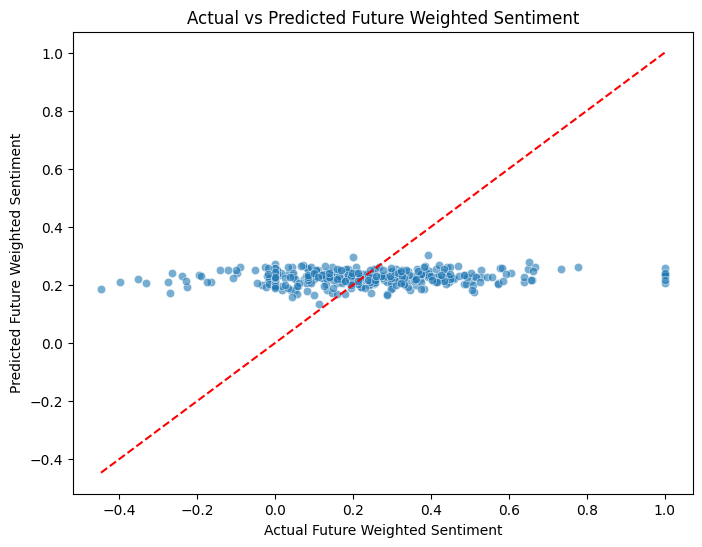

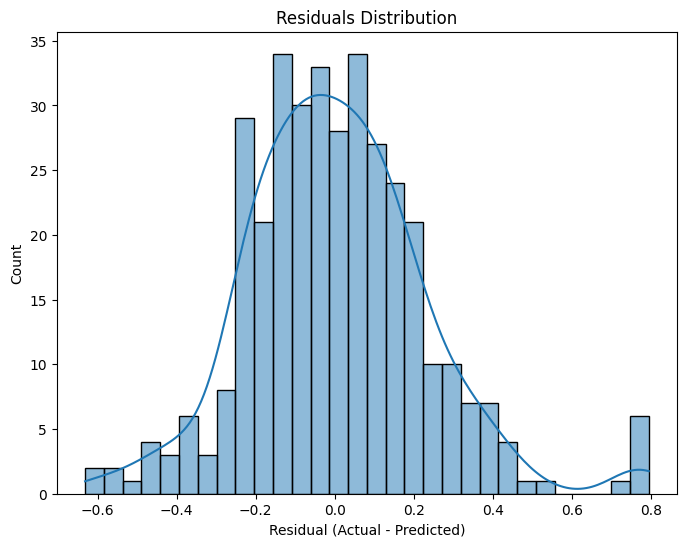

7-day Future Weighted Sentiment Prediction for user 'bobette.riner@ipgdirect.com':

      date  weighted_sentiment_future  predicted_weighted_sentiment_future
2010-04-18                   0.252932                             0.201829
2010-05-27                   0.050907                             0.181800
2010-06-03                   0.042401                             0.157617
2010-06-15                   0.147914                             0.190594
2010-08-04                  -0.239911                             0.230888
2010-08-16                   0.309794                             0.252958
2010-08-24                   0.196093                             0.239840


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visualize Actual vs Predicted for the test set

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Future Weighted Sentiment')
plt.ylabel('Predicted Future Weighted Sentiment')
plt.title('Actual vs Predicted Future Weighted Sentiment')
plt.show()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.show()

# 2. Create 7-day prediction table

# Join X_test back with dates and 'from' (user) info for interpretability
# We need to get the indices of the test set back to the original features_targets_df rows
test_indices = y_test.index

# Extract corresponding rows
pred_table = features_targets_df.loc[test_indices, ['weighted_sentiment_future']].copy()
pred_table['predicted_weighted_sentiment_future'] = y_pred
pred_table['date'] = unique_dates.loc[test_indices, 'date'].values
pred_table['from'] = unique_dates.loc[test_indices, 'from'].values

# Sort by date and user
pred_table = pred_table.sort_values(['from', 'date'])

# Pick one user to display the next 7 days of predictions (or fewer if not available)
user_to_show = pred_table['from'].iloc[0]  # first user in test set
user_pred_table = pred_table[pred_table['from'] == user_to_show].head(7)

# Format date for display
user_pred_table['date'] = user_pred_table['date'].dt.date

print(f"7-day Future Weighted Sentiment Prediction for user '{user_to_show}':\n")
print(user_pred_table[['date', 'weighted_sentiment_future', 'predicted_weighted_sentiment_future']].to_string(index=False))

<style>
table {
  width: 80%;
  border-collapse: collapse;
  margin-bottom: 20px;
}
th, td {
  border: 1px solid #ddd;
  padding: 10px;
  text-align: left;
}
th {
  background-color: #f2f2f2;
}
h2 {
  color: #007bff;
  margin-top: 1.5em;
  margin-bottom: 0.5em;
}
</style>

<div>
  <h2>Model Performance</h2>
  <table>
    <thead>
      <tr>
        <th>Metric</th>
        <th>Value</th>
        <th>Interpretation</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Mean Squared Error (MSE)</td>
        <td>0.0513</td>
        <td>Indicates moderate error; average squared deviation between predicted and actual future sentiment.</td>
      </tr>
      <tr>
        <td>R² Score</td>
        <td>0.0144</td>
        <td>Very low — model explains only ~1.4% of the variance in future sentiment.</td>
      </tr>
    </tbody>
  </table>

  <h2>Feature Coefficients (Impact on Predicted Sentiment)</h2>
  <table>
    <thead>
      <tr>
        <th>Feature</th>
        <th>Coefficient</th>
        <th>Interpretation</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>emails_past_30d</td>
        <td>+0.0102</td>
        <td>More emails = slightly more positive future sentiment (very weak signal).</td>
      </tr>
      <tr>
        <td>weighted_sentiment_past</td>
        <td>–0.0101</td>
        <td>Slightly surprising: higher past sentiment slightly correlates with lower future sentiment. Could indicate fluctuating behavior.</td>
      </tr>
      <tr>
        <td>avg_score_past</td>
        <td>–0.0159</td>
        <td>Higher scoring messages in the past predict lower future sentiment. Suggests score doesn’t align well with future emotional tone.</td>
      </tr>
      <tr>
        <td>avg_length_past</td>
        <td>–0.0047</td>
        <td>Longer messages slightly predict more negativity. Possibly longer complaints?</td>
      </tr>
      <tr>
        <td>interaction_sent_len</td>
        <td>+0.0047</td>
        <td>Interaction of sentiment and length offers very minor positive signal.</td>
      </tr>
      <tr>
        <td>day_of_week</td>
        <td>–0.0080</td>
        <td>Day effect is almost negligible; slightly lower sentiment on later weekdays.</td>
      </tr>
    </tbody>
  </table>
</div>